In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

hide_toggle()

In [2]:
# Setting a random seed
import numpy as np
RANDOM_STATE = 99
np.random.seed(RANDOM_STATE)

# Linear Regression

The goal of this notebook is to introduce Linear Regression, __from a practical standpoint__ to users with little to no familiarity. We won't be taking a deep-dive into theory in this notebook. We will instead be focused on quick exposure to the basics of Linear Regression so you can go implement it and learn the nuances for yourself.

Linear Regression is a type of __Supervised Machine Learning__, and while it is often considered a simple model, it is also a great introduction to the basics of Machine Learning.

Hopefully after going through this notebook, you will be able to implement Regression yourself, on problems that you're interested in. There's no quick solution to learn a very dense topic in just a few days - but you can get quick exposure, and then build a deeper understanding as you go. This style of learning is called [__Mind Map Learning__](https://www.teachthought.com/literacy/drawing-ideas-the-benefits-of-mindmapping-for-learning/)


# Table of Contents

1. [A Quick Refresher on Linear Equations](#refresher)
2. [What is Linear Regression](#intro)
3. [Fitting the Regression Line](#fit)
4. [Implementing Linear Regression with Statsmodels](#statsmodels)
5. [Centering and Scaling Predictors](#scaling)
6. [Regression Diagnostics](#diagnostics)
7. [Feature Transformations](#eng)
8. [Implementing Linear Regression with Scikit-learn](#sklearn)
9. [The Bias / Variance Tradeoff](#bias)
10. [Validation Set Strategy and Cross-Validation](#validation)
11. [Regularization](#regularization)


# Section 1. A Quick Refresher on Linear Equations

<a id="refresher"></a>

---

```Disclaimer: If you're already somewhat familiar with Linear Regression and are hoping to reinforce your knowledge of it, I recommend jumping ahead to Section 2```

You might have come across the following equation in early eduction:

$$
y = mx + b
$$

This is a simple equation of a straight line, where `y` is any y-coordinate, `m` is the slope of the line, `x` is any x-coordinate, and `b` is the y-intercept. 

`m`, the `slope` is the change in y for a 1-unit change in x. So if the slope is 0.5, every time x increases by 1, y increases by 0.5. This is given by the equation below:


$$
slope = \frac{\Delta y}{\Delta x}
$$

## Practice

Let's give a quick example. When x = 10, y = 100. The slope is 4. What is y when x=20?


$$
100 + 4*(20-10) = 140
$$

And another quick example. When x1 = 5, y1 = 100. When x2 = 15, y2 = 200. Calculate the slope, `m`.

$$
slope = \frac{\Delta y}{\Delta x} = \frac{y_2-y_1}{x_2-x_1} = \frac{200-100}{15-5} = \frac{100}{10} = 10
$$

These two examples were obviously very simplistic views, however they're good to keep in mind as you go along. 

## An example in Python
Let's demonstrate this further in Python for the linear equation:

$$
y = 0.5x + 1
$$

We'll calculate the values of this line from x=0 to x=10

In [3]:
# Creating a function to represent the line
m = 0.5
b = 1

def f(x, m, b):
    return m*x + b

In [4]:
# Instantiating our X-values. In this case 
# we're choosing the range from x=0 to x=10
xs = range(0,11)
print('X values:')
print(list(xs))

X values:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [5]:
# Calculating y values
ys = []
for x in xs:
    y = f(x, m ,b)
    ys.append(y)

print('y values:', ys)

y values: [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0]


Now, let's plot the data using matplotlib

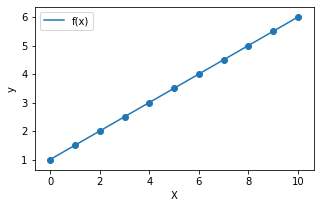

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,1, figsize=(5, 3))
ax.plot(xs, ys, label = 'f(x)')
ax.scatter(xs, ys)
ax.set_xlabel('X') ; ax.set_ylabel('y')
plt.legend()

As you can see above, the output of our function, `f(x)` is a straight line as expected. each marker is an (x,y) coordinate.

To get you ready for the rest of this notebook, I'm going to show you how to replicate this function using `NumPy`, a popular Python module for working with multidimensional data in a vectorized manner. NumPy's main advantage it is incredibly fast; Python is not the quickest language, but since NumPy does most of it's heavy-lifting with C/C++ it is much quicker than executing typical Python code. If you're interested in a career in Data Science, NumPy is a must-have in your toolkit

In [7]:
import numpy as np

# First, we're making a numpy array of our x values
xs = np.arange(0,11)
print('X values:')
print(xs)

X values:
[ 0  1  2  3  4  5  6  7  8  9 10]


In [8]:
# Next, we're going to predict y-values with our function f(x)
ys = f(xs, m , b) 
print('y values:')
print(ys)

y values:
[1.  1.5 2.  2.5 3.  3.5 4.  4.5 5.  5.5 6. ]


Notice how we didn't have to use a for loop to calculate each y value iteratively (one-at-a-time). 

Below is the plot once again, however this time using seaborn to switch things up

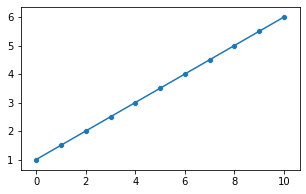

In [9]:
import seaborn as sns
# Plot
fig, ax = plt.subplots(1,1, figsize=(5, 3))
sns.lineplot(xs, ys, ax=ax)
sns.scatterplot(xs, ys, ax=ax)

Now that you have a refresher on simple linear equations, let's get back to Linear Regression

Linear Regression is simply a way to take some data that you have, and determine the best `slope` and `intercept` to represent that data. You're `fitting` some linear equation, to your data. 


# Section 2. What is Linear Regression?

<a id="intro"></a>

---

The main goal of Linear Regression is to predict some target variable, `y`, through some predictor variable, `X`.

A really simple example: predicting someones height (`y`) based on their weight (`X`). Obviously taller individuals are expected to weigh more. In this case, Linear Regression can be used to _predict the average height at each given weight._

The data for this might look something like below

In [10]:
import pandas as pd
Howell1 = 'https://github.com/rmcelreath/rethinking/raw/master/data/Howell1.csv'
df = pd.read_csv(Howell1, delimiter=';')
df = df[df.age >= 18] # Only looking at individuals over 18 years old

df[['height', 'weight']].head(5)

,height,weight
0,151.765,47.825606
1,139.700,36.485807
2,136.525,31.864838
3,156.845,53.041915
4,145.415,41.276872


And plotting this data looks something like this

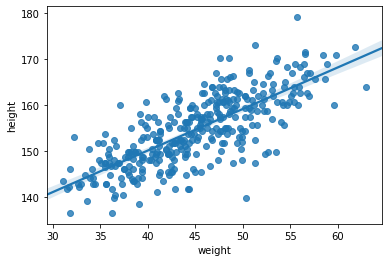

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.regplot(df['weight'], df['height'])
plt.show()

As you can see above, the line does a good job of capturing the trend between weight and height. The line itself is actually running through the average value of `height` at each given value of `x`, `weight`. __It doesn't predict the exact value of each y, it predicts the average value of y at each x value__. You can see in this case, for example, at 60kg, the predicted average y value is roughly 168cm, simply by looking at the regression line. 

(135, 182)

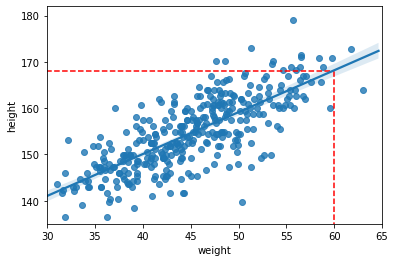

In [12]:
line = sns.regplot(df['weight'], df['height'])
plt.vlines(x=60, ymin=0, ymax=168, color='r', linestyle='--')
plt.hlines(y=168, xmin=0, xmax=60, color='r', linestyle='--')

plt.xlim(30,65)
plt.ylim(135,182)


__The equation for linear regression is as follows:__

$$
\hat{y} = \beta_0 + \beta_1 X_1 + \dots + \beta_n X_n + \epsilon_i
$$

* $\hat{y}$ is the dependent (y) variable

* $\beta_0$ is the y-intercept, which is equivalent to `b` from earlier

* $X_n$ is a given variable in our model In our example, it is weight, however there can be many variables in a model.

* $\beta_n$ is the slope for variable $X_n$, which is equivalent to `m` from earlier. This is an important point to bear in mind. __For each X (independent) variable, there is a slope for it__

* $\epsilon_i$ is the random error component. The Linear Regression model assumes that there is some random error component to a model that is randomly and normally distributed around the regression.

# Section 3: Fitting the Regression Line

<a id="fit"></a>

---
__So how is a regression line fit?__ Typically through a fitting technique called `Ordinary Least Squares (OLS)`, which attempts to choose the `slope` and `intercept` parameters that minimize the distance between the observed data points and the regression line. 

Below is a simple plot to illustrate this fitting procedure. 

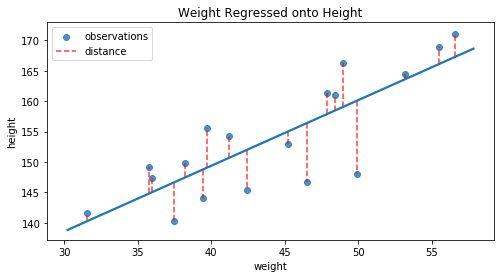

In [13]:
import scipy.stats as scs

# Making the dataset smaller for easy visualization
df1 = df.sample(frac = 0.05, random_state=RANDOM_STATE) 

# Plotting the regression line
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.regplot(df1['weight'], df1['height'], ci=None, ax=ax, label='observations')
# Using scipy to quickly get a regression line - I don't recommend this typically
slope_1, intercept_1, r_value, pval, std_err = scs.linregress(df1['weight'],df1['height'])

# We're going to have to make predictions for the plot, so here's f(x) again
def f(x, m, b):
    return m*x + b

# separate the positive and negative residuals for easier plotting
predictions = f(df1.weight, slope_1, intercept_1)
positive_residuals = df1[df1.height > predictions]
negative_residuals = df1[df1.height <= predictions]

# Plot Residuals
ax.vlines(positive_residuals['weight'], 
          f(positive_residuals.weight, slope_1, intercept_1), 
          positive_residuals['height'], 
          linestyle='--', color='red', alpha=0.75, label='distance')

ax.vlines(negative_residuals['weight'], 
          f(negative_residuals.weight, slope_1, intercept_1),
          negative_residuals['height'], 
          linestyle='--', color='red', alpha=0.75)

plt.title('Weight Regressed onto Height')
plt.legend()
hide_toggle()

The plot above shows the regression line, which is the line that minimizes the total distance between the y-values and the predictions, represented by the dashed red lines. These verticals distances between the data points and the regression line are known as the __residuals__.

This total distance is typically measured via the __Sum of Squared Errors (SSE)__. 

## Sum of Squared Errors (SSE)

$$
SSE = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

Try not to let this equation scare you too much. Let's break it down.

__First__, $\sum_{i=1}^{n}$, which represents the sum for each observation from $observation_1$ to $observation_n$ where _n_ is the total number of observations. For our dataframe below, there are 352 rows, so n=352. 

In [14]:
print('\nnumber of observations, n: {}'.format(len(df)))
df[['weight', 'height']].head() # .head() shows the first 5 rows


number of observations, n: 352


,weight,height
0,47.825606,151.765
1,36.485807,139.700
2,31.864838,136.525
3,53.041915,156.845
4,41.276872,145.415


__Next__, $(y_i - \hat{y}_i)^2$, which represents the squared errors, aka the difference (squared, of course) between the observed value of y and the predicted value of y at each value of x.
 * Each observation is represented by $y_i$, so for example $y_5$ is observation 5
 * Each prediction is represented by $\hat{y}_i$, spoken plainly as "y-hat-i"

__Bringing it all together__, the equation represents calculating the squared error for each observation, and then taking the total sum of all those squared errors. This process is illustrated below

In [15]:
# Quickly obtaining the regression line to illustrate the SSE process 
slope, intercept, r_value, pval, std_err = scs.linregress(df['weight'],df['height'])
# Making predictions from the slope and intercept obtained above
df['height_prediction'] = df['weight']*slope+intercept 
df[['weight', 'height', 'height_prediction']].head()

,weight,height,height_prediction
0,47.825606,151.765,157.162960
1,36.485807,139.700,146.900111
2,31.864838,136.525,142.718000
3,53.041915,156.845,161.883870
4,41.276872,145.415,151.236164


In this case, y is `height`, and $\hat{y}$ is `height_prediction`. Alright now that we have our 352 predictions, we're going to calculate the sum of squared error using our equation 

$$
SSE = \sum_{i=1}^{352} (y_i - \hat{y}_i)^2
$$



In [16]:
df['errors'] = (df['height'] - df['height_prediction'])
df['sq_errors'] = df['errors']**2

df[['weight', 'height', 'height_prediction', 'errors', 'sq_errors']].head()

,weight,height,height_prediction,errors,sq_errors
0,47.825606,151.765,157.162960,-5.397960,29.137968
1,36.485807,139.700,146.900111,-7.200111,51.841592
2,31.864838,136.525,142.718000,-6.193000,38.353243
3,53.041915,156.845,161.883870,-5.038870,25.390213
4,41.276872,145.415,151.236164,-5.821164,33.885954


As you can see above, we generated an error for each row, $(y_i - \hat{y}_i)$ and subsequently a squared error term, $(y_i - \hat{y}_i)^2$

__We'll now calculate SSE__

In [17]:
SSE = df['sq_errors'].sum()

print('The sum of squared error is SSE = {}'.format(round(SSE,2)))

The sum of squared error is SSE = 9054.79


### So why are we squaring the error term?

There are two main reasons:

1. So that the errors do not cancel themselves out
2. To add more weight to predictions that are worse

___
### 1. Preventing the errors from cancelling themselves out

The error term is squared so that there are only positive values. Let's go back to our regression plot from earlier.

Text(0.5, 1.0, 'Weight Regressed onto Height')

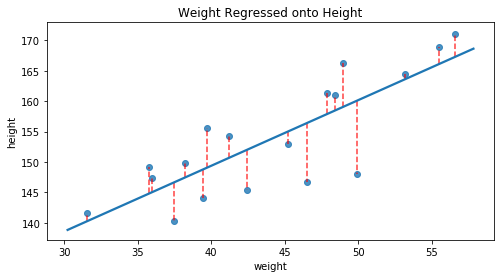

In [18]:
# Plotting the regression line
fig, ax = plt.subplots(1,1,figsize=(8,4))
sns.regplot(df1['weight'], df1['height'], ci=None, ax=ax)
# Plot Residuals
ax.vlines(positive_residuals['weight'], f(positive_residuals.weight, slope_1, intercept_1), positive_residuals['height'], linestyle='--', color='red', alpha=0.75)
ax.vlines(negative_residuals['weight'], f(negative_residuals.weight, slope_1, intercept_1),negative_residuals['height'], linestyle='--', color='red', alpha=0.75)
plt.title('Weight Regressed onto Height')

Now, consider what would happen if we only summed the errors (the length of the red dashed lines), where some are negative and some are positive, and not the squared errors. This is executed in code below:

In [19]:
df['errors'].sum()

-8.952838470577262e-12

As shown above they just cancel eachother out, and we'd have no understanding of the magnitude of the error. This is exactly why we square the error terms. Since they are all in the same direction (i.e. all positive values), the summed error now represent the magnitude of the error.

### 2. Adding more weight to bad predictions

By squaring our terms, we are adding more weight to bad predictions. So if a prediction is off by 10, it is weighted as $10^2 = 100$, and if a prediction is off by 50, it is weighted as $50^2 = 2500$. It can basically help account for situations when there are a few data points that really don't fit the model.

__Let's get back on topic: we want to choose the regression line that fits the data the best.__ We can accomplish this by finding the 2 parameters, `m` (slope) and `b` (intercept), that minimizes the SSE. Technically there is a little more going on in the background algebraically , but we won't get into that here. 

If you want to explore more on your own, Linear Regression can be fit in a few different ways, for example through __`Ordinary Least Squares`__, __`Maximum Likelihood Estimation`__, or __`Gradient Descent`__.

Let's get started with implementing Linear Regression in Python

# Section 4: Implementing Linear Regression with Statsmodels

<a id="statsmodels"></a>

---

## Part a:  One Variable Linear Regression
Let's get started implementing linear regression with a popular module, `Statsmodels`

In [20]:
import statsmodels.api as sm

# Let's declare our X and y variables
X = df['weight']
y = df['height']

# With Statsmodels, we need to add our intercept term, B0, manually
X = sm.add_constant(X)
X.head()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,weight
0,1.0,47.825606
1,1.0,36.485807
2,1.0,31.864838
3,1.0,53.041915
4,1.0,41.276872


As you can see, the `sm.add_constant()` added a `const` vector (column) to our dataframe that is simply a vector of ones. This is used to represent $B_0$, the intercept. Now let's fit the model

In [21]:
# This procedure below is how the model is fit in Statsmodels
model = sm.OLS(endog=y, exog=X)
results = model.fit()
# Show the summary
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     463.3
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           4.68e-66
Time:                        23:02:38   Log-Likelihood:                -1071.0
No. Observations:                 352   AIC:                             2146.
Df Residuals:                     350   BIC:                             2154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.8794      1.911     59.589      0.000     110.121     117.638
weight         0.9050      0.042     21.524      0.000       0.822       0.988
==============================================================================
Omnibus:                        5.258   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.729
Skew:                          -0.180   Prob(JB):                       0.0570
Kurtosis:                       3.511   Cond. No.                         321.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

__Congrats, here's your first regression model.__

That's a lot of information to digest at once. Let's start to break this down

## R-squared

$R^2$: Also known as the `coefficient of determination`. By definition, it is _the proportion of variance in y that is explained by X_, shown in the equation below

$$ 
R^2 = 1 - \frac{SS_{res}}{SS_{tot}}
$$

__But what does that even mean?__ 

* $R^2$ is basically how well the model explains the data. 
* A value of 1.0 means that the variance in the y-values are 100% explained by the X-values.
* A negative $R^2$ value means that using the average value of y is a better predictor than the regression equation
* $R^2$ is also just the square term of the `correlation coefficient` $R$
    * We won't get into this too much, but you can quickly calculate the correlation coefficient via the following:

`.corr()` calculates $R$ between all pairs of variables

In [22]:
df[['weight', 'height']].corr()['height']

weight    0.754748
height    1.000000
Name: height, dtype: float64

   And squaring this $R$ term yields $R^2$

In [23]:
df[['weight', 'height']].corr()['height']**2

weight    0.569644
height    1.000000
Name: height, dtype: float64

Let's get back on topic. Here's a simplified equation for $R^2$:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y}_i)^2}
$$

That top term should look familiar - it's the `sum of squared error`. The bottom term is the `variance` of y where $\bar{y}$ is the mean of y. We can calculate this by hand from our dataset

In [24]:
# We had already calculated SSE from above
print('Sum of Squared Error of predictions: {}'.format(round(SSE,2)))
# Calculating total Variance, (y - y_bar)^2
y_variance = np.sum( (df['height'] - df['height'].mean() )**2)
print('Total variance in y: {}'.format(round(y_variance,2)))
# Now calculating R^2
r2 = 1 - SSE/y_variance
print('R^2: {}'.format(round(r2, 2)))

Sum of Squared Error of predictions: 9054.79
Total variance in y: 21040.24
R^2: 0.57


### Adjusted R-squared and Feature hacking
Adjusted $R^2$ is simply $R^2$ adjusted by the number of predictors (X-variables). 

$$ 
R^2 adjusted = 1 - \frac{(1-R^2)(N-1)}{N-p-1}
$$

where `p` is the number of predictors and `N` is the number of observations. 

It's important to understand that as you add more features (X-variables) to your model, your $R^2$ will begin to approach 1.0, even if the features are nonsense. I'll illustrate this below

In [25]:
df2 = df.copy()
df2.drop(['age', 'male', 'height_prediction', 'sq_errors', 'errors'],axis=1, inplace=True)
# Making 300 randomized features
for i in range(300):
    # We're just adding random variables now with mu=0, sigma=10
    df2['weight_{}'.format(i)] = np.random.normal(0, 10, len(df2))

y2 = df2.pop('height')
X2 = sm.add_constant(df2)
model2 = sm.OLS(y2,X2)
results2 = model2.fit()

print('R^2:',results2.rsquared)
print('Adj. R^2:', results2.rsquared_adj)

R^2: 0.9267891684601794
Adj. R^2: 0.4860599625904597


As you can see, $R^2$ is approaching 1.0 (it was originally 0.570, and it is now 0.927) just by adding random variables that mean nothing, however adjusted $R^2$ has remained closer to the actual relationship. 

### Beta Coefficients

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.570
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     463.3
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           4.68e-66
Time:                        23:02:38   Log-Likelihood:                -1071.0
No. Observations:                 352   AIC:                             2146.
Df Residuals:                     350   BIC:                             2154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        113.8794      1.911     59.589      0.000     110.121     117.638
weight         0.9050      0.042     21.524      0.000       0.822       0.988
==============================================================================
Omnibus:                        5.258   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                5.729
Skew:                          -0.180   Prob(JB):                       0.0570
Kurtosis:                       3.511   Cond. No.                         321.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Taking a look back at our Statmodels output, we can extract the coefficients summary below:

In [27]:
results.summary2().tables[1]

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,113.879394,1.911065,59.589485,2.557528e-185,110.120777,117.638010
weight,0.905029,0.042048,21.523960,4.684660e-66,0.822332,0.987727


The `Coef.` column represent the value of the __Beta Coefficients__. In this case, the `Coef.` for `const` is the __intercept__ term, and the `Coef.` for `weight` is the __slope__ of the regression line. __The model is stating that as weight increases by 1kg, height increase by 0.905 cm__. This interpretation is incredibly useful, and one of the most common inferences in Data Science. 

The `Std.Err.` Is the error associated with the Beta coefficients. It's important to be aware that the Standard Error estimates can be skewed if the feature itself is not normally distributed (which is why you may commonly see log-transforms in practice). We won't go into this now, but like I said, be aware of it.

`P>|t|` is a hypothesis test that tests if the associated Beta Coefficient is non-zero, and is therefore significantly associated with the dependent variabe, y. If you are not familiar with hypothesis tests, you can use the rule of thumb that if you see `P>|t|` of < 0.05, the Beta coeficient is signficant In this case, both Beta Coefficients are significant.

*A side note: while `P>|t|` < 0.05 is extremely common in practice, it is a dangerous and arbitrary assumption. I recommend exploring hypothesis testing further on your own.*

`[0.025 0.975]` is the 95% confidence interval of the Beta Coefficient

### Summary

In general, when reading these summaries you should look for 3 things:
 1. A high $R^2$ 
 2. The coeficient values
 3. A `P>|t|` hypothesis test less than 0.05
 
While these aren't meant to be strict criteria, they are good things to prioritize if you're relatively new. As you get more comfortable with Linear Regression and statistics in general, you will become more comfortable interpreting these.

---

### Part b) Multiple Linear Regression

Now we will implement a three variable linear regression, which even includes a boolean value

In [28]:
X = sm.add_constant(df[['weight', 'age', 'male']])
y = df['height']

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     267.8
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           4.81e-90
Time:                        23:02:38   Log-Likelihood:                -1008.8
No. Observations:                 352   AIC:                             2026.
Df Residuals:                     348   BIC:                             2041.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        123.4377      2.022     61.046      0.000     119.461     127.415
weight         0.6342      0.043     14.903      0.000       0.551       0.718
age           -0.0109      0.015     -0.742      0.459      -0.040       0.018
male           6.5574      0.542     12.104      0.000       5.492       7.623
==============================================================================
Omnibus:                       22.884   Durbin-Watson:                   1.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.736
Skew:                          -0.383   Prob(JB):                     5.25e-10
Kurtosis:                       4.526   Cond. No.                         554.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Interpretation

Let's go through this interpretation step by step.
* The $R^2$ value looks pretty good at 0.698. X (weight, age, male) seems to explains much of the variance in y
* The adjusted $R^2$ is pretty close to the $R^2$ value which is a good sign
* The Beta Coeffient `Age` is not significant since `P>|t|` > 0.05. We should drop this from our model. We should do this before we try to interpret any other coefficients, because if there is __multicollinearity__ between predictors, it can throw off their hypothesis tests. As a rule of thumb, drop the feature with the highest p-value (`P>|t|` value) first before judging any of the other features.
    * __Multicollinearity__ is when two of your models features are correlated to eachother. So if `weight` and `age` were correlated with eachother, that would be considered multicollinearity. Wikipedia says it best:
    ```Multicollinearity does not reduce the predictive power or reliability of the model as a whole, at least within the sample data set; it only affects calculations regarding individual predictors. That is, a multivariate regression model with collinear predictors can indicate how well the entire bundle of predictors predicts the outcome variable, but it may not give valid results about any individual predictor, or about which predictors are redundant with respect to others.``` -[source](https://en.wikipedia.org/wiki/Multicollinearity)
    * Multicollinearity is something you will have to be very comfortable with later on, but for now, as a beginner, it is sufficient to simply be wary of it

In [29]:
X = sm.add_constant(df[['weight', 'male']])
y = df['height']

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     401.9
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           2.80e-91
Time:                        23:02:38   Log-Likelihood:                -1009.1
No. Observations:                 352   AIC:                             2024.
Df Residuals:                     349   BIC:                             2036.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        122.7034      1.762     69.626      0.000     119.237     126.169
weight         0.6412      0.041     15.458      0.000       0.560       0.723
male           6.5003      0.536     12.129      0.000       5.446       7.554
==============================================================================
Omnibus:                       22.809   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.837
Skew:                          -0.388   Prob(JB):                     8.23e-10
Kurtosis:                       4.500   Cond. No.                         355.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Let's try interpreting the coefficients again

* `const` aka $\beta_0$, the intercept, is 122.7. So when Male=0 and weight=0, the height is expected to be 122.7cm. Obviously this doesn't make much sense, but it is simply how this model works. Models can have all sorts of weird implications like this but still have great predictive power within their range of x-values that they were trained upon. We're going to re-explore this later when looking at [centering and scaling](#scaling). 
* `weight` is a signficant Beta coefficient with a value of 0.64 (it's slope), meaning that as weight increases by 1kg, height increases by 0.64cm
* `male` is considered a __dummy-coded variable__, which is a boolean series of 0s and 1s. It's a significant Beta coefficient with a value of 6.5. This means that if someone is a male, they are likely to be 6.5cm taller than females at the same weight

Let's plot it out to reinforce this

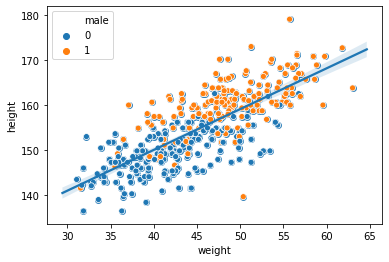

In [30]:
sns.regplot(df['weight'], df['height'])
sns.scatterplot(df['weight'], df['height'], hue = df['male'])
plt.show()

As you can see from the plot above, the right half of the plot is predominantly male, which seems to make sense as you'd expect them to weigh more. 

# Section 5: Centering and Scaling Predictors

<a id="scaling"></a>

---

## Centering

In our earlier example, we came across a weird case that didn't make much sense; our y-intercept (aka our $\beta_0$ coefficient, `const`) had a value of 122cm. For that model, it meant that people with `weight` = 0 were 122cm tall, which makes no sense. 

---

*`To be clear, this scenario is a common one, and it is perfectly acceptable for prediction. Model's have all sorts of strange behaviors outside of their range of known values. However, if you have a set of data points from range X=18 to X=100, making predictions outside of that range 18-100 is something you should try to avoid at all costs. This is known as ` **`extrapolation`**`. The further away from your X-range of data points you get, the more uncertainty you will have in your predictions.`*

---

Getting back on track, how can we help to improve the interpretability of our model? __Centering__ is a common solution. Centering is simply rescaling predictors by subtracting the mean from each value.

$$
x_{i} = X_{i} - \bar{X}
$$

Centering changes the interpretation of the intercept without having an  effect on the slope between predictors and the response variable (`y`).


This is simple to implement with pandas as shown below

Mean Weight: 44.99


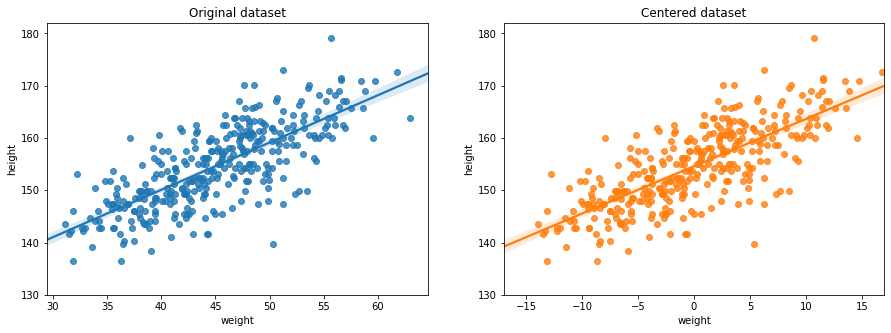

In [31]:
centered_weight = df['weight'] - df['weight'].mean()

print('Mean Weight: {}'.format(round(df['weight'].mean(),2)))

fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.regplot(df['weight'], df['height'], ax=ax[0])
sns.regplot(centered_weight, df['height'], ax=ax[1])
ax[0].set_ylim(130,182);ax[1].set_xlim(-17,17);ax[1].set_ylim(130,182)
ax[0].set_title('Original dataset');ax[1].set_title('Centered dataset')
plt.show()

Taking a look at the X-scales above, it's easy to see that all of the datapoints for the plot on the right are centered around zero. This makes for an better interpretation of the y-intercept:
 * __The y-intercept is now the average value of y at the average value of X.__ So when Weight is at the mean, 45kg, height is at it's mean, 155cm.

Let's take a quick look at the statsmodels summary for the centered dataset. Notice we won't center `male` because it is a boolean series, and not continuous data.

In [32]:
df_centered = df.copy()
df_centered['weight_centered'] = df_centered['weight'] - df_centered['weight'].mean()
X = sm.add_constant( df_centered[['weight_centered', 'male']] ) 
y = df['height']

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     401.9
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           2.80e-91
Time:                        23:02:39   Log-Likelihood:                -1009.1
No. Observations:                 352   AIC:                             2024.
Df Residuals:                     349   BIC:                             2036.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             151.5501      0.339    446.978      0.000     150.883     152.217
weight_centered     0.6412      0.041     15.458      0.000       0.560       0.723
male                6.5003      0.536     12.129      0.000       5.446       7.554
==============================================================================
Omnibus:                       22.809   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.837
Skew:                          -0.388   Prob(JB):                     8.23e-10
Kurtosis:                       4.500   Cond. No.                         17.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice the outputs are practically the same. The only real difference here is $\beta_0$ aka `const` aka our y-intercept. `const` now represents the average value of y at the average value of `weight` when `male`=0. 

### When should you use centering?
 1. When X=0 is not in the dataset. If X=0 is in the dataset, and it's a meaningful value, it's less important to center as X=0 might have it's own meaning
 2. When your model has dummy-coded predictors (for example, our boolean series for `male`). In our case, the dummy-coded predictor didn't create a need for centering, but some other models do. [Here's a great example](https://www.theanalysisfactor.com/center-on-the-mean/).
 3. When your model has `polynomial terms` (such as $weight^2$)


## Standardization

Before we go any further, let's cover some overlapping and confusing definitions you may commonly hear. I'm going to borrow these definitions from this [excellent article](https://medium.com/@swethalakshmanan14/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff):

```
```__`“Rescaling”`__` a vector means to add or subtract a constant and then multiply or divide by a constant, as you would do to change the units of measurement of the data, for example, to convert a temperature from Celsius to Fahrenheit.`

__`“Normalizing”`__` a vector most often means dividing by a norm of the vector. It also often refers to rescaling by the minimum and range of the vector, to make all the elements lie between 0 and 1 thus bringing all the values of numeric columns in the dataset to a common scale.`

__`“Standardizing”`__` a vector most often means subtracting a measure of location and dividing by a measure of scale. For example, if the vector contains random values with a Gaussian distribution, you might subtract the mean and divide by the standard deviation, thereby obtaining a “standard normal” random variable with mean 0 and standard deviation 1.`
`

Standardization is extremely important when creating `interaction terms` between two or more predictors that have different units. By standardizing predictors with different units, they will now be directly comparable, and you will be able to create interaction terms between them with no problems.

The most common type of standardization which we will cover here is **`
Z-score normalization`** (or Standard Scaling). This type of standarization is a two step process, where you center your data and then re-scale it by normalizing it with the standard deviation

$$
z = \frac{x - \mu}{\sigma}
$$
Where $\mu$ (also known as $\bar{x}$) is the mean of x and $\sigma$ is the standard deviation of $x$. This standardization re-scales the x-variable to have a mean of 0 and a standard deviation of 1.

In [33]:
def standardize(series):
    return (series - series.mean()) / series.std()

Mean Weight: 44.99


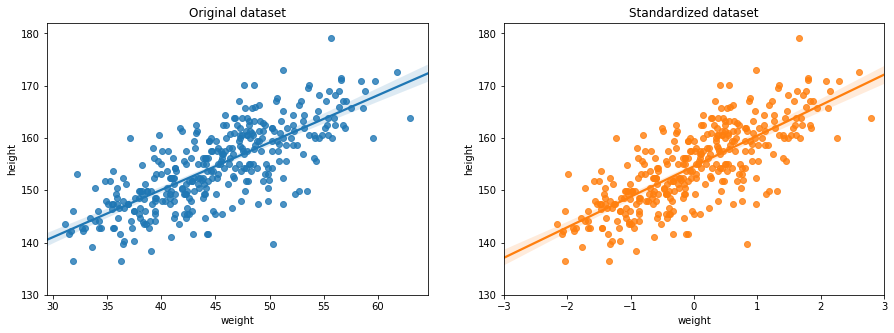

In [34]:
standardized_weight = standardize(df['weight'])

print('Mean Weight: {}'.format(round(df['weight'].mean(),2)))
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.regplot(df['weight'], df['height'], ax=ax[0])
sns.regplot(standardized_weight, df['height'], ax=ax[1])
ax[0].set_ylim(130,182);ax[1].set_xlim(-3,3);ax[1].set_ylim(130,182)
ax[0].set_title('Original dataset');ax[1].set_title('Standardized dataset')
plt.show()

As you can see, the X-scale for the standardized plot is now in units of standard deviations. Let's take a look at the statsmodels output

In [35]:
df_standardized = df.copy()
df_standardized['weight_standardized'] = standardize(df_standardized['weight'])
X = sm.add_constant(df_standardized[['weight_standardized', 'male']])
y = df['height']

model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.697
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                     401.9
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           2.80e-91
Time:                        23:02:40   Log-Likelihood:                -1009.1
No. Observations:                 352   AIC:                             2024.
Df Residuals:                     349   BIC:                             2036.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 151.5501      0.339    446.978      0.000     150.883     152.217
weight_standardized     4.1399      0.268     15.458      0.000       3.613       4.667
male                    6.5003      0.536     12.129      0.000       5.446       7.554
==============================================================================
Omnibus:                       22.809   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.837
Skew:                          -0.388   Prob(JB):                     8.23e-10
Kurtosis:                       4.500   Cond. No.                         3.14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Something really important has changed in the summary above. The Beta Coefficient for `weight` is now in units of standard deviations. This can be interpreted as:

__As `weight` increases by 1 standard deviation, `height` increases by 4.14cm__.

That's going to be a real head scratcher when trying to interpret regression models at a high level, or when explaining to your non-technical peers. I recommend using `sklearn's` `StandardScaler()` function so that you can transform your Beta-coefficient back into it's original units.

In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Standardize weight
weight_std = scaler.fit_transform(df[['weight']])
round(weight_std.mean()), round(weight_std.std())

(0.0, 1.0)

As you can see, it is very easy to use Z-score Standarization with this module. More importantly, you can transform your standardized values back into their original form. Let's do this with our standardized $\beta$ coefficient for `weight`. In it's original form which we saw earlier, $\beta_{weight}$ = 0.6412, however in it's standardized form, $\beta_{weight}$ = 4.1399. 

Using our `scaler` object, we'll transform $\beta_{weight}$ back to it's unstandardized form

In [37]:
4.1399 / scaler.scale_

array([0.64209083])

By dividing the standardized $\beta$ coefficient by the stored standard deviation for `weight` we were able to estimate the unstandardized $\beta_{weight}$

# Section 6: Regression Diagnostics

<a id="diagnostics"></a>

---

In this section we will take a quick look at regression diagnostics. There's a lot to cover here, so the goal will be moreso to introduce topics for your awareness than to fully understand them. Hopefully you will explore these further as you practice regression more.

## Multicollinearity

We're going to generate a fake dataset, where `X1` and `X2` are correlated with eachother, and see how this impacts the statsmodels output. 

In [38]:
X1 = np.random.normal(0,1, 1000)
X2 = X1 * 0.8 + np.random.normal(0,0.05, 1000)
y1 = 15*X1 + np.random.normal(0,5, 1000) # y = mX + b

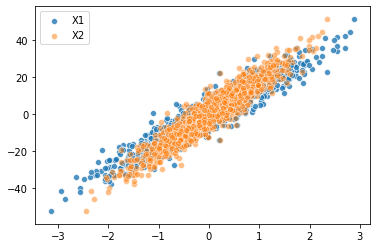

In [39]:
sns.scatterplot(X1, y1, alpha=0.8, label='X1')
sns.scatterplot(X2, y1, alpha=0.5, label='X2')
plt.legend()

Keep in mind, we know that the true relationship between X1 and y1 is 15, as we generated y1 ourself.

Here's the X1 vs. y1 model. Looks good!

In [40]:
res = sm.OLS(y1, sm.add_constant(sm.add_constant(X1))).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     8840.
Date:                Sun, 05 Jan 2020   Prob (F-statistic):               0.00
Time:                        23:02:40   Log-Likelihood:                -3014.8
No. Observations:                1000   AIC:                             6034.
Df Residuals:                     998   BIC:                             6043.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1040      0.156     -0.666      0.506      -0.410       0.202
x1            14.8800      0.158     94.021      0.000      14.569      15.191
==============================================================================
Omnibus:                        8.054   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                9.270
Skew:                           0.132   Prob(JB):                      0.00971
Kurtosis:                       3.390   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now here's X2 vs. y1, for reference. In this case we know that y1 is not a function of X2, however X2 is correlated to X1. This is knowledge you will rarely have. So we'll pretend as if we didn't know these true relationships

In [41]:
res = sm.OLS(y1, sm.add_constant(sm.add_constant(X2))).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.895
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     8524.
Date:                Sun, 05 Jan 2020   Prob (F-statistic):               0.00
Time:                        23:02:40   Log-Likelihood:                -3031.1
No. Observations:                1000   AIC:                             6066.
Df Residuals:                     998   BIC:                             6076.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1634      0.159     -1.030      0.303      -0.475       0.148
x1            18.5396      0.201     92.326      0.000      18.146      18.934
==============================================================================
Omnibus:                        5.178   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                5.832
Skew:                           0.085   Prob(JB):                       0.0542
Kurtosis:                       3.333   Cond. No.                         1.27
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

X2 looks like it's correlated to y1, which makes sense. Under typical circumstances where we don't have this knowledge of the function y1, it would make sense that someone would want to fit a model using both X1 and X2 as predictors. So let's do that.

In [42]:
res = sm.OLS(y1, sm.add_constant(sm.add_constant(np.c_[X1,X2]))).fit() # np.c_[x1,x2] concatenates two numpy vectors
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     4417.
Date:                Sun, 05 Jan 2020   Prob (F-statistic):               0.00
Time:                        23:02:40   Log-Likelihood:                -3014.7
No. Observations:                1000   AIC:                             6035.
Df Residuals:                     997   BIC:                             6050.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1085      0.156     -0.693      0.488      -0.416       0.199
x1            13.7655      2.386      5.770      0.000       9.084      18.447
x2             1.3942      2.978      0.468      0.640      -4.449       7.238
==============================================================================
Omnibus:                        7.891   Durbin-Watson:                   2.086
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                9.091
Skew:                           0.129   Prob(JB):                       0.0106
Kurtosis:                       3.389   Cond. No.                         30.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

_Quick note, the warnings at the bottom of the statsmodels summary sometimes actually warn us of multicollinearity! Keep an eye on them_

Now, all of a sudden, the true relationship between X1 and y1 is masked by the presence of X2 in the model. $\beta_{X1}$ should be roughly equal to 15, however now it is quite different. __This is the danger of multicollinearity, and you should always be wary of it__. This applies not just to Regression models, but many other models throughout Machine Learning. It's important to be very aware of this, and I encourage you to read further on your own.

We can test for multicollinearity through __Variance Inflation Factors__.

In [43]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Z-score Standardizing X
scaler = StandardScaler()
scaled_Xs = pd.DataFrame(scaler.fit_transform(np.c_[X1, X2]), columns =['X1', 'X2'])
# Adding constant
features = sm.add_constant(scaled_Xs)
# Creating a dataframe of Variance inflation factors
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(features.values, i) for i in range(features.shape[1])]
vif["features"] = features.columns
vif

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,VIF Factor,features
0,1.000000,const
1,227.039644,X1
2,227.039644,X2


Values of more than 4 or 5 are sometimes regarded as being moderate to high, with values of 10 or more being regarded as very high. In this case the VIF factor is over 200. These are extremely collinear and 1 of the two features should be removed. We can confirm in 2 ways:
 * 1. A heatmap of the correlations using pandas `.corr()`
 * 2. Plotting the X variables against eachother

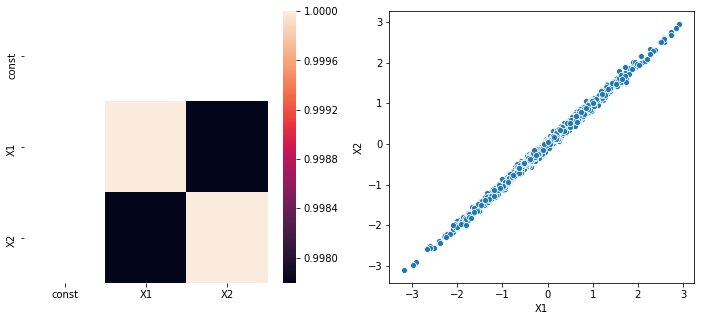

In [44]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.heatmap(features.corr(), ax = ax[0])
sns.scatterplot(features['X1'], features['X2'], ax=ax[1])

Heatmaps work great when you have a large amount of features. When you only have 2 such as this, you might as well just use the `.corr()` function and look at the values

In [45]:
features.corr()

,const,X1,X2
const,NaN,NaN,NaN
X1,NaN,1.000000,0.997795
X2,NaN,0.997795,1.000000


## Diagnostic Plots

In [46]:
from statsmodels.graphics.gofplots import ProbPlot

def resid_v_fitted(fitted_y, y, ax):
    '''Plots the residuals vs. fitted yvalues'''
    sns.residplot(fitted_y, y,
          lowess=True, scatter_kws={'alpha': 0.5},
          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},ax=ax)
                 
    ax.set_title('Residuals vs Fitted')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

def normal_QQ_plot(norm_residuals, ax):
    QQ = ProbPlot(norm_residuals)
    QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', lw=1, ax=ax)
    ax.set_title('Normal Q-Q')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Standardized Residuals')
    abs_norm_resid =norm_residuals.sort_values(ascending=False)
     
    
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    for r, i in enumerate(abs_norm_resid_top_3.index):
        ax.annotate(i, xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                        norm_residuals[i]));

def scale_loc_plot(fitted_y, norm_residuals, norm_residuals_abs_sqrt, ax=ax):
    ax.scatter(fitted_y, norm_residuals_abs_sqrt, alpha=0.5);
    sns.regplot(fitted_y, norm_residuals_abs_sqrt,
              scatter=False,
              ci=False,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax)
    ax.set_title('Scale-Location')
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('$\sqrt{|Standardized Residuals|}$');

    # annotations
    abs_norm_resid = norm_residuals.sort_values(ascending=False)
    abs_norm_resid_top_3 = abs_norm_resid[:3]
    abs_sq_norm_resid = norm_residuals_abs_sqrt.sort_values(ascending=False)
    abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
 
    for i in abs_norm_resid_top_3.index:
        ax.annotate(i, xy=(fitted_y[i],
                norm_residuals_abs_sqrt[i]))
        
def residuals_v_leverage_plot(norm_residuals, model_leverage,ax):
    ax.scatter(model_leverage, norm_residuals, alpha=0.5);
    sns.regplot(model_leverage, norm_residuals, scatter=False,
              ci=False, lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8}, ax=ax)
    
    ax.set_xlim(0, max(model_leverage)+0.01)
    ax.set_ylim(-3, 5)
    ax.set_title('Residuals vs Leverage')
    ax.set_xlabel('Leverage')
    ax.set_ylabel('Standardized Residuals')
    
        
def diagnostic_plots(model, X, y, return_high_leverage=False):
    fitted_y = model.fittedvalues
    residuals = model.resid
    norm_residuals = pd.Series(model.get_influence().resid_studentized_internal, index=fitted_y.index)
    norm_residuals_abs_sqrt = pd.Series(np.sqrt(np.abs(norm_residuals)), index=fitted_y.index)
    model_abs_resid = pd.Series(np.abs(residuals), index=fitted_y.index)
    model_leverage = pd.Series(model.get_influence().hat_matrix_diag, index=fitted_y.index)
    avg_leverage = model_leverage.mean()
    model_cooks = pd.Series(model.get_influence().cooks_distance[0], index=fitted_y.index)
    fig, ax = plt.subplots(2,2, figsize=(12,10))
    # Residuals vs. Fitted
    resid_v_fitted(fitted_y, y, ax=ax[0,0])
    # Normal QQ Plot
    normal_QQ_plot(norm_residuals, ax=ax[0,1])
    # Scale-Location
    scale_loc_plot(fitted_y, norm_residuals, norm_residuals_abs_sqrt, ax=ax[1,0])
    # Residuals vs. Leverage
    residuals_v_leverage_plot(norm_residuals, model_leverage,ax=ax[1,1])
    if return_high_leverage:
        return model_leverage[model_leverage > avg_leverage*2]
    
hide_toggle()

We will use the function `diagnostic_plots()` which is in the cell above (click the `Toggle show/hide` button if you're interested), to create the diagnostic plots. These plots were widely popularized as they are built into `R`s regression module, and of course because they're very useful.

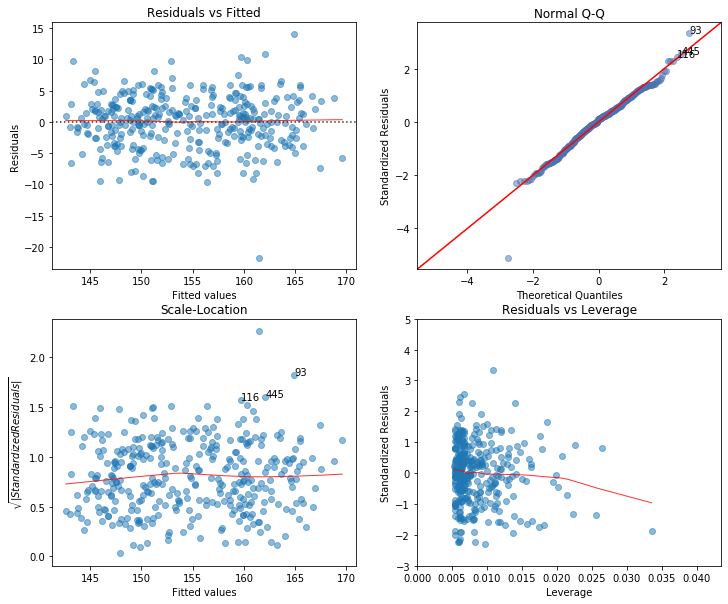

In [47]:
diagnostic_plots(results, X, y)

### Plot 1: Residuals vs Fitted plot

This is probably the most important plot to understand, and it's easy to apply this same idea to any other model you work with, regression or otherwise.

The X-axis is the __Fitted Values__, which are the y-predictions, and the y-Axis is the __Residuals__ which represet the difference between the predictions and the actual y-values. Your goal with this plot should be to make sure that your observations are normally distributed around zero, with equal variance at each point. For this example, it's near perfect, as you can see the observations are normally distributed around zero with few outliers. 

It's very common to see trumpet / fan shaped plots for these, which tend to indicate that their is __heteroscedascity__ present (we'll talk about this in a little bit), or you'll see a pattern in them (highlighted through the red spline) which indicates there is a pattern that you are not accounting for. In that case you should do some feature engineering. 

### Plot 2: Normal Q-Q plot

This plot indicates if the residuals are normally distributed, reinforcing the idea from the `Residuals vs Fitted` plot. If the residuals follow a straight line, they are more normally distributed, abd if they deviate secerely they may not be so normal and there could be a pattern in your data you are missing.

### Plot 3: Scale Location plot

This is an even better plot than the `Residuals vs Fitted` plot to look for __heterosceasticity__, meaning unequal variance. One of the main assumptions of an Ordinary Least Squares model like the one we're using is equal variance throughout, or __homoscedasticity__. Here's a quick example of what heteroscedasticity might look like:

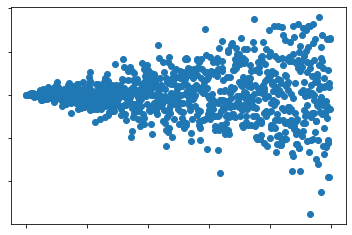

In [48]:
fig, ax = plt.subplots(1,1)
ax.scatter(np.arange(0,1000), (np.random.normal(0,5, size = 1000) * np.arange(1,1000+1)));
ax.set_yticklabels([]); ax.set_xticklabels([]);
hide_toggle()

It's important to understand heteroscedasticity. If it is present in your model, the standard errors of your beta coefficients will be skewed, however the predictions tend to stay in-tact, as well as the values of the beta coefficients. In summary, it's really important for estimating errors, however less important if your simply generating predictions. If you find heteroscedasticity in your model, you can try feature transformations, such as `log` or `sqrt`, or even `box-cox transformations` to make your predictor have a normal distribution, or you could try a `Weighted Least Squares` model. We won't cover that here, but I encourage you to read more on your own.

### Plot 4: Residuals vs. Leverage plot

This plot is useful to identify high-__leverage__ points, which can severly skew a model. __Leverage__ is a form of outlier, where instead of having an extreme y-value, the observation has an extreme x-value. Here's a quick example below

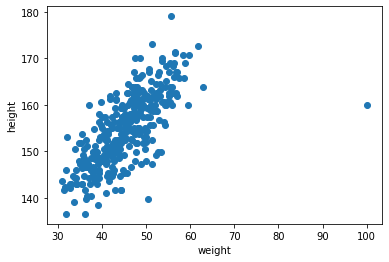

In [49]:
x1 = np.concatenate((df['weight'].values, np.array([100])))
y1 = np.concatenate((df['height'].values, np.array([160])))
plt.scatter(x1,y1);plt.ylabel('height');plt.xlabel('weight');

hide_toggle()

As you can see above, the observation at (weight=100, height=160) is extremely far from the rest of the dataset and is considered a __high-leverage point__. __Leverage can typically influence the fit of a model far more than y-outliers__ While it's always a big decision to remove any observations from a dataset, high leverage points tend to be the best candidates for this.

### What do bad diagnostic plots look like?

So far, for the dataset we've been using, we have only been looking at individuals over the age of 18. Let's look at the full dataset now. As shown below, there is a polynomial trend, since people under 18 grow quicker than those over 18.

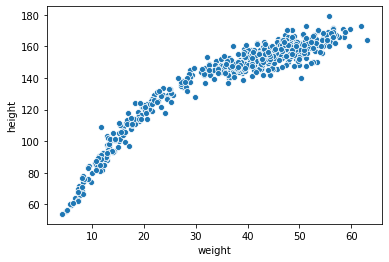

In [50]:
import pandas as pd
Howell1 = 'https://github.com/rmcelreath/rethinking/raw/master/data/Howell1.csv'
df = pd.read_csv(Howell1, delimiter=';')
sns.scatterplot(df['weight'], df['height'])


Now we'll look at the diagnostic plots using the same features as our earlier examples. We will standardize for this case

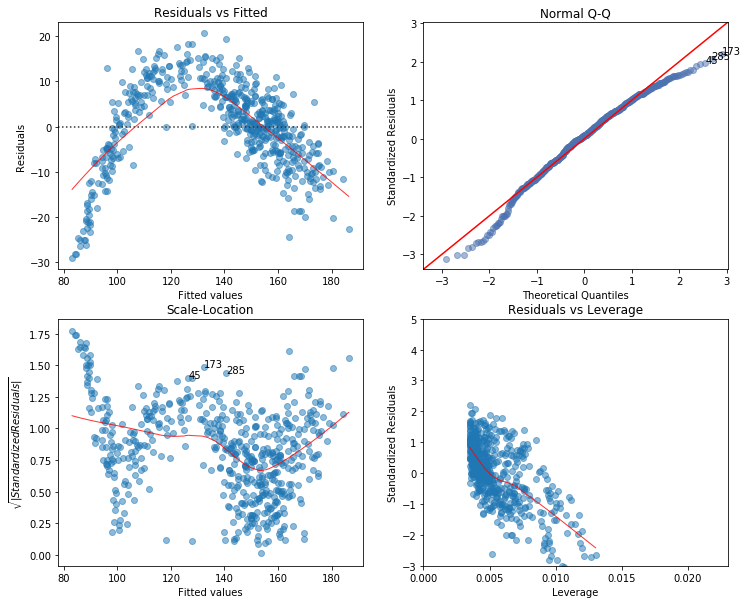

In [51]:
df_standardized = df.copy()
df_standardized['weight_standardized'] = standardize(df_standardized['weight'])
X = sm.add_constant(df_standardized[['weight_standardized', 'male']])
y = df['height']

model = sm.OLS(y, X); results = model.fit();
diagnostic_plots(results, X, y)

hide_toggle()

As you can see, there is a clear trend in the __Residuals vs. Fitted__ plot, which is further brought out in the __Scale Location Plot__. The Normal Q-Q plot looks fine, and there are no high leverage points.

In the next section, we'll explore how to fit a better model on this dataset

# Section 7: Feature Transformations and Engineering

<a id = "eng"></a>

---

In this section we'll go over the following:
 - Polynomial Regression
 - Interaction Terms
 - Log / Square Root Transforms
 
## Polynomial Regression

Our dataset above is a great candidate for polynomial regression. Here's the plot again:

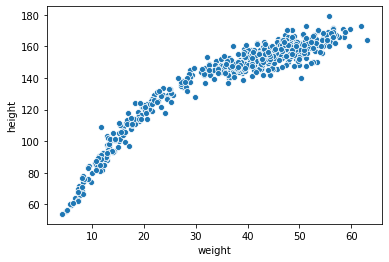

In [52]:
import pandas as pd
Howell1 = 'https://github.com/rmcelreath/rethinking/raw/master/data/Howell1.csv'
df = pd.read_csv(Howell1, delimiter=';')

sns.scatterplot(df['weight'], df['height'])

Let's try to add both $X^2$ and $X^3$ terms to the model. It's important to note that if you are going to add a polynomial term to your model, it's important to keep the polynomial terms of lower orders, even if they have an insignificant p-value. I.e. if an $X^3$ term is significant, you should also include the $X$ and $X^2$ terms in the model

### $Weight^2$

We'll use Sklearn's `PolynomialFeatures` module. The output of the `fit_transform()` method is a numpy array containing the transformed Polynomial Features. In this case it contains the original $weight$ in the first column, and $weight^2$ in the second column

In [53]:
from sklearn.preprocessing import PolynomialFeatures

# degree = 2 indicates X^2. `include_bias` adds the constant
PN = PolynomialFeatures(degree=2, include_bias=False) 
PN.fit_transform(df[['weight']])

array([[  47.8256065 , 2287.28863709],
       [  36.4858065 , 1331.21407596],
       [  31.864838  , 1015.36790077],
       ...,
       [  54.0624965 , 2922.75352781],
       [   8.051258  ,   64.82275538],
       [  52.5316235 , 2759.57146755]])

We will use numpy slicing to extract just the $X^2$ term and add it to our dataframe

In [54]:
# array[:,1] selects all rows (:), for column idx 1
df['weight_2'] = PN.fit_transform( df[['weight']] )[:,1] 

In [55]:
# Preparing X features
scaler = StandardScaler()
scaled_features = pd.DataFrame(scaler.fit_transform(df[['weight', 'weight_2']]), columns = ['weight_s', 'weight_2s'], index= df.index)
df1 = pd.concat((df, scaled_features), axis=1)
X = sm.add_constant(df1[['weight_s', 'weight_2s', 'male']])
# fitting model
y = df1['height']
results = sm.OLS(y, X).fit()
results.summary()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.962
Method:                 Least Squares   F-statistic:                     4557.
Date:                Sun, 05 Jan 2020   Prob (F-statistic):               0.00
Time:                        23:02:45   Log-Likelihood:                -1686.8
No. Observations:                 544   AIC:                             3382.
Df Residuals:                     540   BIC:                             3399.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        136.2201      0.327    416.097      0.000     135.577     136.863
weight_s      64.7747      1.197     54.094      0.000      62.422      67.127
weight_2s    -39.9719      1.210    -33.039      0.000     -42.348     -37.595
male           4.3255      0.490      8.821      0.000       3.362       5.289
==============================================================================
Omnibus:                        9.538   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.008   Jarque-Bera (JB):               13.185
Skew:                           0.152   Prob(JB):                      0.00137
Kurtosis:                       3.699   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This model looks much better. As you can see, all of the including features are significant (`P>|t|` < 0.05) and the $R^2$ is high. Let's plot this model.

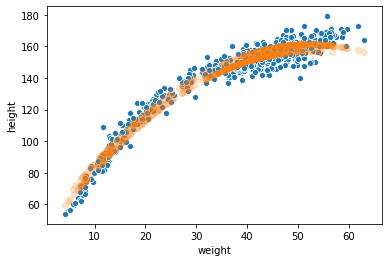

In [56]:
sns.scatterplot(df['weight'], df['height'])
plt.scatter(df['weight'], results.predict(X), alpha=0.2)

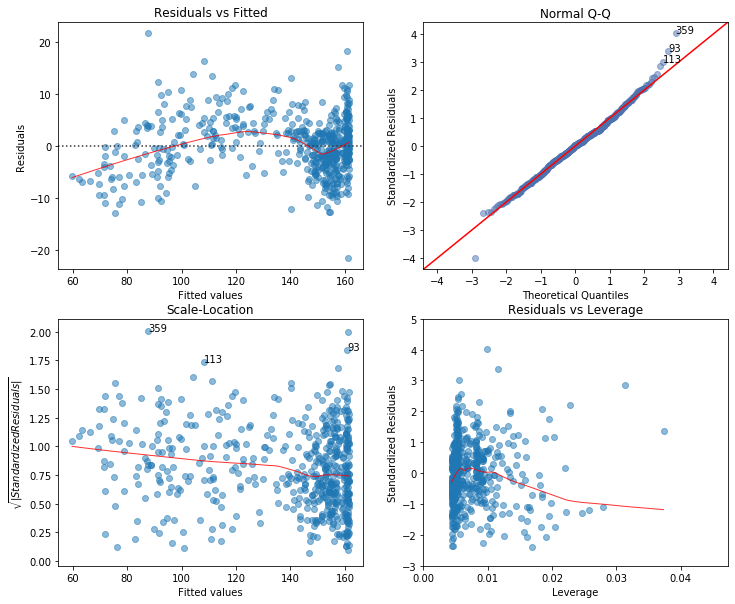

In [57]:
diagnostic_plots(results, X, y)

This certainly looks better, but there is definitely still some weird behavior in the `Residuals vs. Fitted` plot. Let's try a model with a `weight` feature with a polynomial degree of 3

### Polynomial of  degree=3

In [58]:
PN = PolynomialFeatures(degree=3, include_bias=False) # degree = 2 indicates X^2. `include_bias` adds the constant
df['weight_3'] = PN.fit_transform(df[['weight']])[:,2]

In [59]:
scaler = StandardScaler()

scaled_features = pd.DataFrame(scaler.fit_transform(df[['weight', 'weight_2', 'weight_3']]), columns = ['weight_s', 'weight_2s', 'weight_3s'], index= df.index)
df2 = pd.concat((df, scaled_features), axis=1)

X = sm.add_constant(df2[['weight_s', 'weight_2s', 'weight_3s', 'male']])
y = df2['height']
results = sm.OLS(y, X).fit()
results.summary()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     4795.
Date:                Sun, 05 Jan 2020   Prob (F-statistic):               0.00
Time:                        23:02:46   Log-Likelihood:                -1597.2
No. Observations:                 544   AIC:                             3204.
Df Residuals:                     539   BIC:                             3226.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        136.6749      0.280    488.664      0.000     136.125     137.224
weight_s     107.7630      3.134     34.383      0.000     101.606     113.920
weight_2s   -136.4463      6.732    -20.268      0.000    -149.671    -123.222
weight_3s     55.2225      3.808     14.500      0.000      47.741      62.704
male           3.3629      0.422      7.977      0.000       2.535       4.191
==============================================================================
Omnibus:                       16.927   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.113
Skew:                          -0.031   Prob(JB):                     8.73e-09
Kurtosis:                       4.278   Cond. No.                         72.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

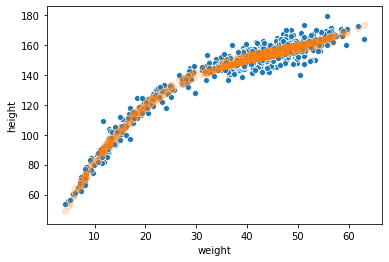

In [60]:
sns.scatterplot(df['weight'], df['height'])
plt.scatter(df['weight'], results.predict(X), alpha=0.2)

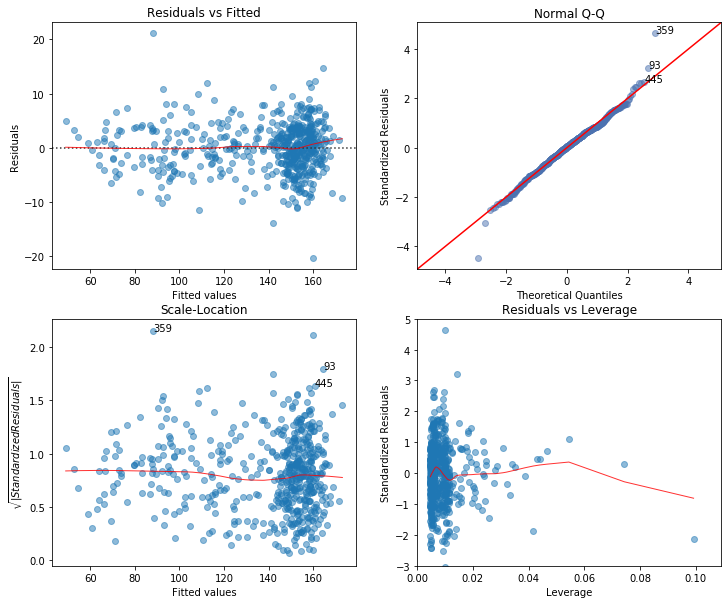

In [61]:
diagnostic_plots(results, X, y)

The `Residuals vs Fitted` and `Scale-Location` plots look much better now. This is a good model.

__It's important to note when you're adding more polynomial terms to your model, that the fewer you add, the better.__ 
It's very common to see a plot such as the following to evaluate which Polynomial term should be used:

Text(0, 0.5, 'Mean Squared Error')

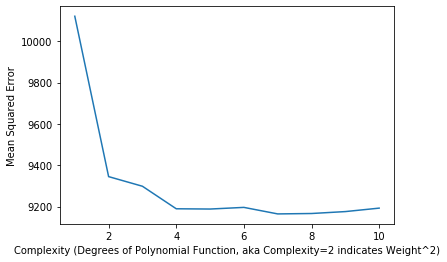

In [62]:
complexity_plot = np.empty((10,2))
for i in range(1,11): # testing Polynomial(i=1) to Polynomial(i=10)
    PN = PolynomialFeatures(degree=i); scaler = StandardScaler();
    weight = scaler.fit_transform( PN.fit_transform( df[['weight']] ) )
    X = np.c_[weight, df.male.values]; y = df['height'];
    _res = sm.OLS(y,X).fit()
    complexity_plot[i-1] = [i, _res.mse_resid]

plt.plot(complexity_plot[:,0], complexity_plot[:,1])
plt.xlabel('Complexity (Degrees of Polynomial Function, aka Complexity=2 indicates Weight^2)')
plt.ylabel('Mean Squared Error')

People commonly use what is called the __Elbow Method__ with these sort of plots, where they eyeball the bottom left most point with the relatively low complexity and relatively low error. In this plot, complexity = 2 which is $weight^2$ and complexity = 3 which is $weight^4$ both look like good candidates

There is a good case here to only use $weight^2$ instead of $weight^3$ or $weight^4$, because $weight^3$ and $weight^4$ only provide a marginal improvement in fit. It's easy to argue for either case in this scenario, however some scenarios you will come across will be far more obvious. The more polynomial terms you have, the more `bias` you will introduce to your model, and the more likely you are to overfit. We will go over this later in the [Bias vs. Variance Tradeoff](#bias) section. 

## Interaction Terms

__Interactions Terms__ are used to account for when multiple X variables have an interaction effect between them that influences y significantly more than the sum of its parts. Say for instance you have an interaction effect between X1 and X2, you can represent the interaction as shown below:

$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2
$$

We're going to work with a new dataset for this example, from the excellent book, `Introduction to Statistical Learning`. It's a really solid book for anyone interested in getting started in the Data Science field.

### What does the data look like?

In [63]:
advertising = pd.read_csv('http://faculty.marshall.usc.edu/gareth-james/ISL/Advertising.csv').drop('Unnamed: 0',axis=1)
advertising.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


For this dataset, we're interested in number of `sales` (in units of 1000s of sales. So 22.1 sales is equivalent to 22,100 sales) as our target variable, and `TV`, `radio`, and `newspaper` is the amount of money spent (in \\$1000s of dollars) on ads for those respective categories. Let's generate some quick plots.

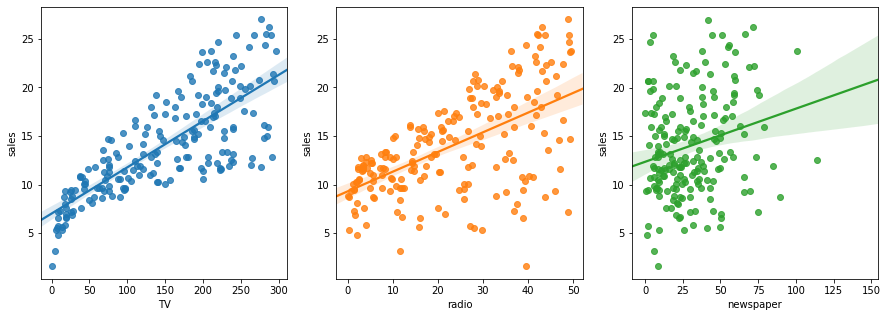

In [64]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.regplot(advertising['TV'], advertising['sales'], ax=ax[0])
sns.regplot(advertising['radio'], advertising['sales'], ax=ax[1])
sns.regplot(advertising['newspaper'], advertising['sales'], ax=ax[2])

### Is there any multicollinearity in the dataset?

First, we'll look at a heatmap. The only corerlations that are high look to be correlations with sales

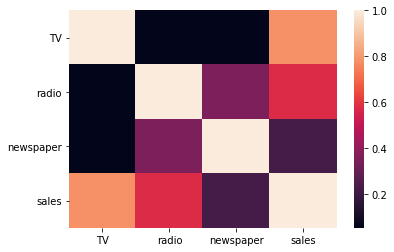

In [65]:
sns.heatmap(advertising.corr())

Next we'll look at __variance inflation factors__

In [66]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(advertising.values, i) for i in range(advertising.shape[1]-1)]
vif["features"] = advertising.columns[:3]
vif

,VIF Factor,features
0,23.198876,TV
1,12.570312,radio
2,3.153498,newspaper


As you can see, it looks like there is some multicollinearity as indicated by `VIF`, however, our features are not standardized. Let's standardize them and see how they really look.

In [67]:
scaler = StandardScaler()
X_features = scaler.fit_transform(advertising[['TV', 'radio', 'newspaper']])

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_features, i) for i in range(advertising.shape[1]-1)]
vif["features"] = advertising.columns[:3]
vif

,VIF Factor,features
0,1.004611,TV
1,1.144952,radio
2,1.145187,newspaper


Good news there's no multicollinearity to be alarmed about. That is also an important lesson, scale your features before checking. Now we'll generate a simple linear model to understand the relationship between the predictors and the target

In [68]:
scaler = StandardScaler()
X_ad = scaler.fit_transform( advertising[['TV', 'radio', 'newspaper']] )
X_ad = pd.DataFrame(X_ad, columns = ['TV', 'radio', 'newspaper'])
X_ad = sm.add_constant( X_ad )

y_ad = advertising.sales
res1 = sm.OLS(y_ad, X_ad).fit()
res1.summary()

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           1.58e-96
Time:                        23:02:49   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0225      0.119    117.655      0.000      13.787      14.258
TV             3.9193      0.119     32.809      0.000       3.684       4.155
radio          2.7921      0.128     21.893      0.000       2.541       3.044
newspaper     -0.0225      0.128     -0.177      0.860      -0.274       0.229
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         1.46
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Identifying interaction effects

Next we're going to look for interaction effects. Below is a really naive plotting method that is useful for idenfitying interaction terms
 1. Take two features (`X1` and `X2`) and a target variable, `y`
 2. Make 1 of the 2 features, `X1`, a boolean series. If the value of an observation is greater than the median of that feature, label it `1` as a `High` category and otherwise `0` as a low category
 3. Plot the other feature, `X2`, against `y`. Now set the `hue` of your plot to be the boolean series for `X1`
 4. If you see separation between the two colors, such as with `Sales vs. TV x radio` and `Sales vs. TV x newspaper`, than it is likely that there is an interaction effect present. Taking a look at `Sales vs. newspaper x radio` there is no real difference between the two colors, and it is likely that there is no interaction present

Text(0.5, 1.0, 'Sales vs. newspaper x radio')

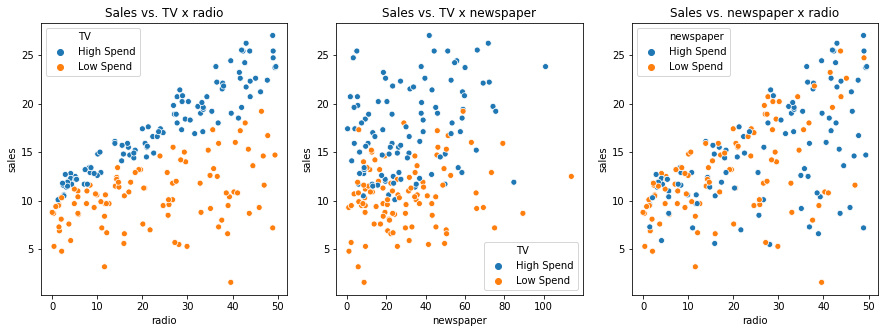

In [69]:
# TV spend greater than median TV spend, boolean series
tv_bool = ( advertising['TV'] > advertising['TV'].median() ).replace({True:'High Spend', False:'Low Spend'}) 
# news spend greater than median
news_bool = ( advertising['newspaper'] > advertising['newspaper'].median() ).replace({True:'High Spend', False:'Low Spend'}) 

fig, ax = plt.subplots(1,3, figsize=(15,5))
sns.scatterplot(advertising['radio'], advertising['sales'], hue=tv_bool, ax=ax[0]).set_title('Sales vs. TV x radio')
sns.scatterplot(advertising['newspaper'], advertising['sales'], hue=tv_bool, ax=ax[1]).set_title('Sales vs. TV x newspaper')
sns.scatterplot(advertising['radio'], advertising['sales'], hue=news_bool, ax=ax[2]).set_title('Sales vs. newspaper x radio')

We'll use this to construct some interaction terms. Considering `newspaper` didnt have a significant relationship with `sales` we're going to drop it. We'll model our interaction terms as the following:

$$
sales = \beta_0 + \beta_1 TV + \beta_2 radio + \beta_3 (TV \cdot radio) + \epsilon
$$

Rearranging this we get:

$$
sales = \beta_0 + (\beta_1 + \beta_3 \cdot radio) \cdot TV + \beta_2 radio  + \epsilon
$$

We can now interpret $\beta_3$ as the increase in the effectiveness of TV advertising for a one unit increase in radio advertising.

we can use the `PolynomialFeatures` module again to create interaction terms

In [70]:
scaler = StandardScaler()
PN = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
scaled_X = scaler.fit_transform( PN.fit_transform(advertising[['TV', 'radio']]) )
X_ad = pd.DataFrame( sm.add_constant(scaled_X) , columns = ['const', 'TV', 'radio', 'TVxradio'])
res2 = sm.OLS(y_ad, X_ad).fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     1963.
Date:                Sun, 05 Jan 2020   Prob (F-statistic):          6.68e-146
Time:                        23:02:49   Log-Likelihood:                -270.14
No. Observations:                 200   AIC:                             548.3
Df Residuals:                     196   BIC:                             561.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0225      0.067    210.180      0.000      13.891      14.154
TV             1.6358      0.129     12.699      0.000       1.382       1.890
radio          0.4274      0.132      3.241      0.001       0.167       0.688
TVxradio       3.6423      0.176     20.727      0.000       3.296       3.989
==============================================================================
Omnibus:                      128.132   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1183.719
Skew:                          -2.323   Prob(JB):                    9.09e-258
Kurtosis:                      13.975   Cond. No.                         5.07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is great, we now have a better fitting model and found a real interaction term! Let's interpret this model

In [71]:
res2.params

const       14.022500
TV           1.635803
radio        0.427411
TVxradio     3.642286
dtype: float64

In [72]:
# we need to unstandardize the coefficients. 
# remember sales is in units of 1000s
coefs = (res2.params[1:] * 1000  / scaler.scale_) 
# Now displaying them
coefs.reset_index().rename(columns={'index':'Predictor',0:'Coefficient'})

,Predictor,Coefficient
0,TV,19.101074
1,radio,28.860340
2,TVxradio,1.086495


 * Our model explains 96.8% of the variation in `sales` through `TV` and `radio` spend. 
 * A \\$1000 increase in spend on `TV` advertising increases `sales` by ($ 20 + 1.1 \cdot radio $) units sold.
 * A \\$1000 increase in spend on `TV` advertising increases `sales` by ($ 29 + 1.1 \cdot TV $)  units sold.

Let's assume that our marketing department decided to spend \\$160,000 on TV and \\$40,000 on radio sales. How much do units do you expect to be sold?

In [73]:
pred_set = scaler.transform([[160, 40, 160*40]])
pred_set = np.concatenate((np.array([1]), pred_set[0]))  
print('Expect there to be {} units sold'.format(
    np.around(res2.predict(pred_set)[0] * 1000)))

Expect there to be 17914.0 units sold


## Feature Transforms

__There are a few key assumptions the Linear Regression makes:__
 1. Linear Relationship between predictors and target
 2. The predictors have a normal distribution
 3. Little multicollinearity
 4. No auto-correlation 
 5. Homoscedasticity
 
Feature transforms can be a quick fix to give predicors a normal distribution or correct for homoscedasticity. Log transforms are one of the most popular, however square root transforms among others are useful.

Feature transforms are a useful way to satisfy some of the assumptions of OLS, one of them being normality in the predictors. While this isn't the most important assumption for making predictions, it is certainly very important to give proper error estimates for the beta coefficients for inference. Log transforms can also correct fot heteroscedasticity.

Let's take a quick look at log transforms

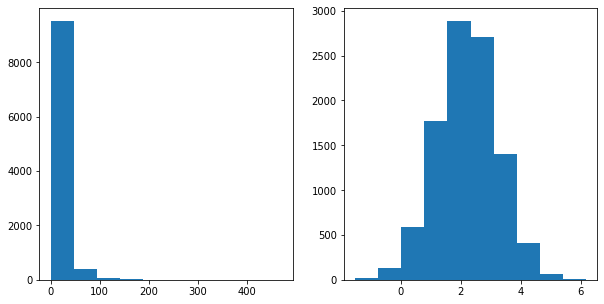

In [74]:
fig, ax = plt.subplots(1,2, figsize=(10,5)) 
# Randomly generated X data
X = np.random.lognormal(2.2, 1.0, 10000)

ax[0].hist(X)
ax[1].hist(np.log(X)+0.01)
plt.show()

As you can see, the log transformation can make a skewed distribution with a heavy tail have a normal distribution. We add 0.01 to each value to avoid log(0) which would return a divide by zero error

In [75]:
np.log(0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


-inf

We can define a function to replicate this behavior, as well as perform the inverse function, $ e^x $, which returns a log transformed value back to its original value

In [76]:
def log_transform(series, invert=False):
    if invert:
        return np.exp(series)-0.01
    return np.log(series+0.01)

Here's an example with an artificial dataset with some heteroscedasticity. I will demonstrate regression on this dataset

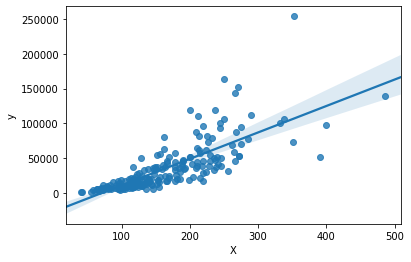

In [77]:
X = np.random.normal(5, 0.4, 200); y = 2*X + np.random.normal(0, 0.4, 200)
X = pd.Series(log_transform(X, invert=True), name='X'); y = pd.Series(log_transform(y, invert=True), name='y')

sns.regplot(X, y)

In [78]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.values.reshape(-1,1))
X_scaled = pd.DataFrame(sm.add_constant(X_scaled), columns = ['const', 'X'])

res = sm.OLS(y, X_scaled).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     291.9
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           8.21e-41
Time:                        23:02:50   Log-Likelihood:                -2288.2
No. Observations:                 200   AIC:                             4580.
Df Residuals:                     198   BIC:                             4587.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.548e+04   1600.034     22.175      0.000    3.23e+04    3.86e+04
X           2.734e+04   1600.034     17.085      0.000    2.42e+04    3.05e+04
==============================================================================
Omnibus:                      124.768   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1142.000
Skew:                           2.243   Prob(JB):                    1.04e-248
Kurtosis:                      13.813   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

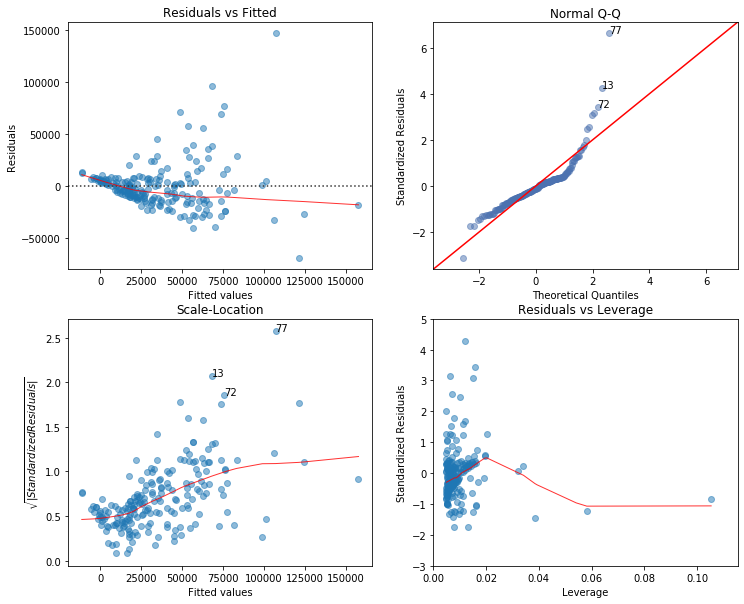

In [79]:
diagnostic_plots(res, X_scaled, y)

Those are some rough looking diagnostic plots with clear __heteroscedasticity__. Let's look back at our predictor to see if we can correct this. We'll define a log transform function below. Note that we add 0.01 to our series, because log(0) returns a divide by zero error. 

Since the inverse of a logarithmic transform is an exponential transform, we can simply perform the exponential transform and subtract 0.01

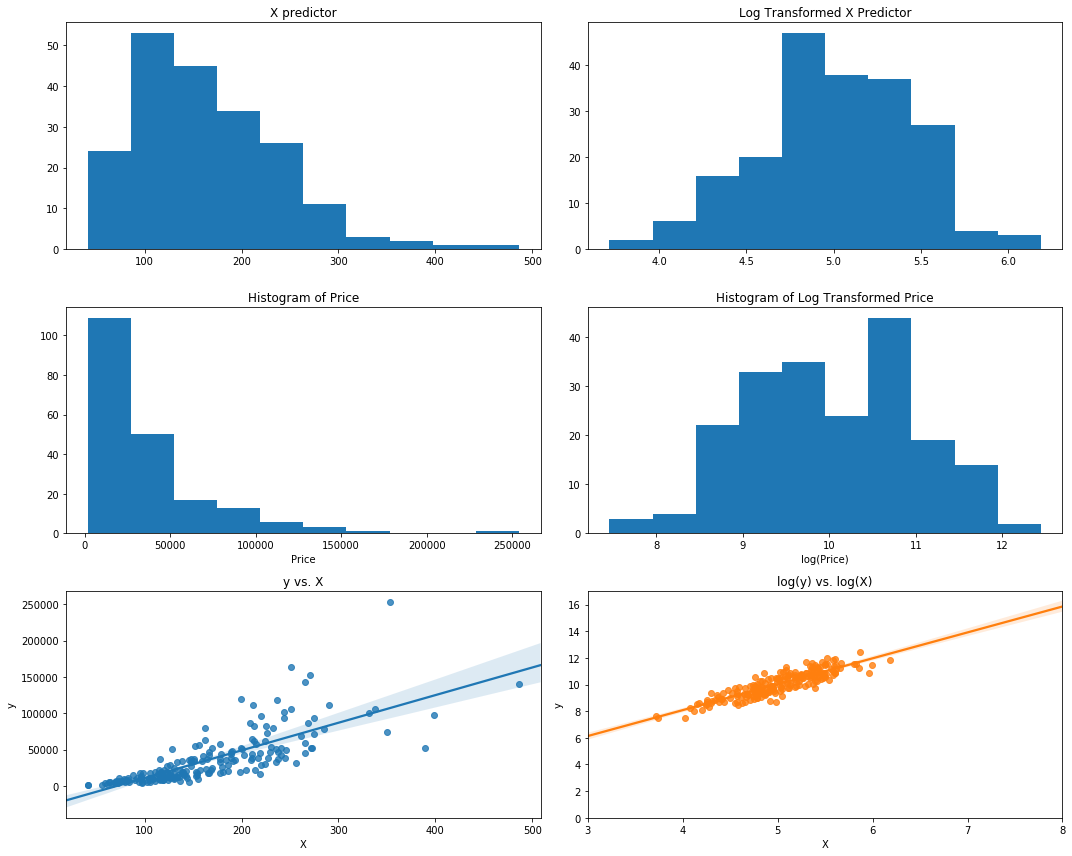

In [80]:
fig, ax = plt.subplots(3,2,figsize=(15,12))
# First Line, X predictor
ax[0,0].hist(X); ax[0,1].hist( log_transform(X) );
ax[0,0].set_title('X predictor'); ax[0,1].set_title('Log Transformed X Predictor'); 
# Second Line, y predictor
ax[1,0].hist(y); ax[1,0].set_title('Histogram of Price'); ax[1,0].set_xlabel("Price");
ax[1,1].hist(log_transform(y)) ; ax[1,1].set_title('Histogram of Log Transformed Price') ; ax[1,1].set_xlabel("log(Price)")
# 3rd Line, regression plots
sns.regplot(X,y, ax=ax[2,0]); sns.regplot(log_transform(X), log_transform(y), ax=ax[2,1])
ax[2,1].set_xlim(3,8); ax[2,1].set_ylim(0,17)
ax[2,0].set_title('y vs. X'); ax[2,1].set_title('log(y) vs. log(X)')

plt.tight_layout()

Great, as you can see the log transforms very extremely useful to reduce the heteroscedasticity, as well as make heavy-tailed X predictors have a normal distribution. 

In [81]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform( log_transform(X).values.reshape(-1,1) )
X_scaled = pd.DataFrame(sm.add_constant(X_scaled), columns = ['const', 'X'])

model_log = sm.OLS( log_transform(y), X_scaled).fit()
model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     690.8
Date:                Sun, 05 Jan 2020   Prob (F-statistic):           1.76e-66
Time:                        23:02:52   Log-Likelihood:                -128.20
No. Observations:                 200   AIC:                             260.4
Df Residuals:                     198   BIC:                             267.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.0377      0.033    307.481      0.000       9.973      10.102
X              0.8580      0.033     26.283      0.000       0.794       0.922
==============================================================================
Omnibus:                        0.555   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.758   Jarque-Bera (JB):                0.682
Skew:                           0.049   Prob(JB):                        0.711
Kurtosis:                       2.731   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

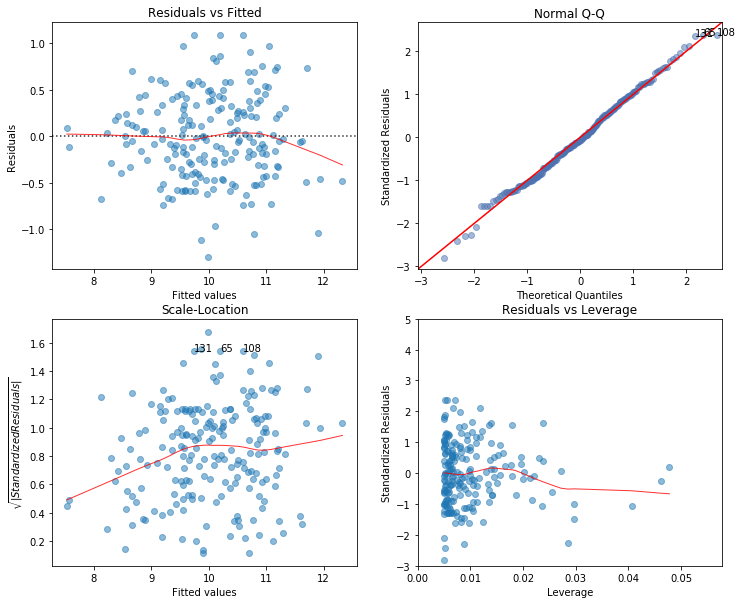

In [82]:
diagnostic_plots(model_log, X_scaled, log_transform(y))

As you can see, the diagnostic plot looks much better. But the scale of the $\beta$ coefficient is completely different now. 

#### Interpreting a model with both dependent (y) and independent (X) variables log-transformed 
Let's say the Beta Coefficient for our X variable above in the log normal model is 0.858. The common interpretation for our model above is a 1% increase in X yields a 0.858% increase in Y.

#### Interpreting a model with only independent (X) variables log-transformed 
Let's say the Beta Coefficient for our X variable is 25630 in a 1 variable Linear Regression model where the X variable is log transformed and the y variable is not. A one percent increase in the independent variable X increases y by ($\beta $ /100), or in this case 256.3.

#### Interpreting a model with only dependent (y) variables log-transformed 
Let's say the Beta Coefficient for our X variable is 0.8103 in a 1 variable Linear Regression model where the y variable is log transformed and the X variable is not. A one unit increase in X increases y by $(e^{\beta} - 1) * 100$, or in this case 123.86.


### Other transforms

Log transformations are just one common transformation out of many other transformations that exist. Some other common ones are below. Keep in mind that all of these lead to different interpretations of regression coefficients.
 - Reciprocal Transformation
 - Square Root Transformation
 - Exponential Transformation 
 - Box-cox Transformation


# Section 8: Implementing Linear Regression with Scikit-Learn

<a id="statsmodels"></a>

---

Let's repeat the process, however this time with `sklearn`. `Scikit-Learn` doesn't have all of the same features as `statsmodels`, specifically hypothesis tests. However, `sklearn` is far better suited for data preparation, predictions, cross validation, pipelines, and many other useful tools. While `statsmodels` is great for understanding your data, `sklearn` is most likely going to be the tool you use to identify the best model.

## Linear Regression Attributes in Sklearn

Let's work with the age dataset again

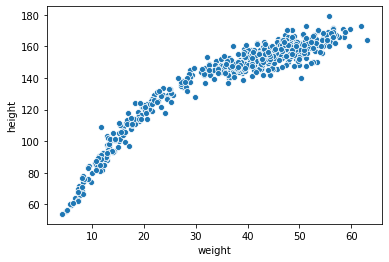

In [83]:
import pandas as pd
Howell1 = 'https://github.com/rmcelreath/rethinking/raw/master/data/Howell1.csv'
df = pd.read_csv(Howell1, delimiter=';')

sns.scatterplot(df['weight'], df['height'])

We'll fit a quick Polynomial Regression to demonstrate the `LinearRegression` attributes

In [84]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# First we'll prepare our X data
Poly = PolynomialFeatures(degree=2, include_bias=False)
Scaler = StandardScaler()
weight = Poly.fit_transform(df[['weight']])
weight_scaled = Scaler.fit_transform(weight)
X = pd.DataFrame(weight_scaled, columns = ['weight', 'weight_sq'])
X['male'] = df['male']

# Instantiate y
y = df['height']

Next we'll fit the model. Notice we don't have to add a constant to our model. This is built into `LinearRegression()` by default

In [85]:
LR = LinearRegression(fit_intercept=True)
LR.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

We can make predictions with `.predict()`. Below is a demonstration of making a height prediction for a 50kg male. Notice we have to do the same X transforms to this data


In [86]:
wt = np.array([[50]]) # 50kg male
wt = Poly.transform(wt)
wt= Scaler.transform(wt)
male = np.array([[1]]) # male = 1
wt = np.c_[wt, male] # Concatenates numpy arrays

pred = LR.predict(wt)
print('Prediction for male with weight 50kg: {} cm'.format( round(pred[0],2) ))


Prediction for male with weight 50kg: 161.16 cm


We can quickly get an R^2 score on the model with .score()

In [87]:
print('R^2:', np.around( LR.score(X,y) , 4 ) )

R^2: 0.962


Let's take a look at the model attributes

__Here are our $ \beta $ coefficients__. Notice how $\beta_0$ is represented by `.intercept_`, and kept separate from `.coef_`

In [88]:
LR.intercept_

136.22010237018276

`.coef_` has values for $\beta_1$ (weight), $\beta_2$ ($weight^2$), and $\beta_3$ (male)

In [89]:
LR.coef_

array([ 64.77466926, -39.97187571,   4.32552806])

## Pipelines

You may have noticed how making predictions was quite complicated, as we had to go through the same feature transformations (Polynomial terms, and scaling). This can be easily simplified through either building your own function, or even better, through `sklearn's` `Pipeline` objects.

I highly recommend becoming comfortable working with Pipeline's, they're incredibly useful for your workflow.

### First, we'll use a Pipeline for continuous numerical features

We'll use the pipeline to perform both polynomial transforms and standardize weight

In [90]:
from sklearn.pipeline import Pipeline

numerical_preprocess = Pipeline([
    ( 'poly', PolynomialFeatures(degree=2, include_bias=False) ),
    ( 'std_scaler', StandardScaler() )
])
# Here's an example of its output
numerical_preprocess.fit_transform(df[['weight']])

array([[ 0.83063275,  0.84577094],
       [ 0.05951381, -0.1613325 ],
       [-0.25471715, -0.49403644],
       ...,
       [ 1.25474816,  1.51515271],
       [-1.87406692, -1.49531535],
       [ 1.15064711,  1.34326108]])

We'll also create a categorical pipeline

Binarizer is just being used for demonstration, in this case our array of [1,0,0] will stay the same after being transformed. Even though this isnt necessary for our example since it isn't changing our male feature,  it is being used as a placeholder to demonstrate what you would do if you had a categorical transformation.

In [91]:
from sklearn.preprocessing import Binarizer
categorical_preprocess = Pipeline([
    ( 'label', Binarizer() )
])

categorical_preprocess.fit_transform(df[['male']])

array([[1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
    

### Next, we'll use Column Transformer 

This will handle our overall data preparation of our X variables, combining our numerical pipeline with our categorical features, in this case $male$

In [92]:
from sklearn.compose import ColumnTransformer

numerical_attributes = ["weight"]
categorical_attributes = ['male']

# Notice how column transformer can take 
# a pipeline object (numerical_preprocess / categorical_preprocess)
# or a transformer object (Binarizer)
preprocess = ColumnTransformer([
        ( "numerical", numerical_preprocess, numerical_attributes ), 
        ( "categorical", Binarizer(), categorical_attributes )
    ])

# Here's a quick demonstration of the output
preprocess.fit_transform(df[['weight', 'male']])

array([[ 0.83063275,  0.84577094,  1.        ],
       [ 0.05951381, -0.1613325 ,  0.        ],
       [-0.25471715, -0.49403644,  0.        ],
       ...,
       [ 1.25474816,  1.51515271,  0.        ],
       [-1.87406692, -1.49531535,  1.        ],
       [ 1.15064711,  1.34326108,  1.        ]])

### Lastly, we'll create a full pipeline

We'll combine our preprocessing step with our `estimator`, `LinearRegression()` to create a full pipeline

In [93]:
# Creating our full pipeline
full_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('LR', LinearRegression(fit_intercept=True))
])

# Instantiating X and y
X = df[['weight', 'male']]
y = df['height']

# Fitting the pipeline
full_pipeline.fit(X, y)

# Instantiating our 50kg male subject to make a prediction on
subjectA = pd.DataFrame({'weight':[50], 'male':[1]})

# Making the prediction
full_pipeline.predict(subjectA)

array([161.16392142])

# Section 9: The Bias / Variance Tradeoff

<a id = "bias"></a>

---

__This is the most important section in this notebook, and a true introduction to Machine Learning__

Let's say for instance, we are working on the height/weight dataset, but we only have access to a subset of the data. With this subset, we are trying to fit a model that represent the true relationship in the population between height and weight for people over 18.

In [94]:
# train_test_split will be used to simulate only 
# having access to a subset of data
from sklearn.model_selection import train_test_split
Howell1 = 'https://github.com/rmcelreath/rethinking/raw/master/data/Howell1.csv'
df = pd.read_csv(Howell1, delimiter=';')
# df = df[df.age >= 18] # Only looking at individuals over 18 years old
X = df[['weight', 'male']]; y = df[['height']];
# Splitting Data
X_subset, X_holdout, y_subset, y_holdout = train_test_split(X, y, test_size=0.2)

Now let's fit the same Polynomial(degree=2) model from earlier

In [95]:
numerical_preprocess = Pipeline([
    ( 'poly', PolynomialFeatures(degree=2, include_bias=False) ),
    ( 'std_scaler', StandardScaler() )
])

preprocess = ColumnTransformer([
        ( "numerical", numerical_preprocess, numerical_attributes ), 
        ( "categorical", Binarizer(), categorical_attributes )
    ])
# Creating our full pipeline
full_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('LR', LinearRegression(fit_intercept=True))
])

In [96]:
full_pipeline.fit(X_subset, y_subset)
full_pipeline.score(X_subset, y_subset)

0.9637385330952922

Next we'll fit a model that performs even better on this subset, with Polnomial(i=23), in this case $weight^{23}$

In [97]:
numerical_preprocess2 = Pipeline([
    ( 'poly', PolynomialFeatures(degree=23, include_bias=False) ),
    ( 'std_scaler', StandardScaler() )
])

preprocess2 = ColumnTransformer([
        ( "numerical", numerical_preprocess2, numerical_attributes ), 
        ( "categorical", Binarizer(), categorical_attributes )
    ])
# Creating our full pipeline
full_pipeline2 = Pipeline([
    ("preprocess", preprocess2),
    ('LR', LinearRegression(fit_intercept=True))
])

In [98]:
full_pipeline2.fit(X_subset, y_subset)
full_pipeline2.score(X_subset, y_subset)

0.9752321200987871

As shown above, this model has an even better $R^2$ than the Poly(i=2) model. So what happens when we try to make predictions on the data that we didnt have access to when fitting our model?

In [99]:
# The weight^2 model
full_pipeline.score(X_holdout, y_holdout)

0.9513983495421683

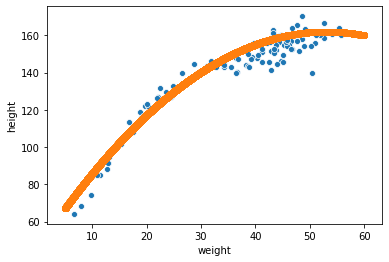

In [100]:
sns.scatterplot(X_holdout['weight'], y_holdout['height'])
Xpred = pd.DataFrame()
Xpred['weight'] = np.linspace(5,60, num=10000)
Xpred['male'] = np.random.binomial(100,0.5, size=10000)


plt.scatter(Xpred['weight'], full_pipeline.predict(Xpred))

In [101]:
len(Xpred), len(y_holdout), len(full_pipeline2.predict(Xpred))

(10000, 109, 10000)

In [102]:
# The weight^(23) model
full_pipeline2.score(X_holdout, y_holdout)

0.9659740405210615

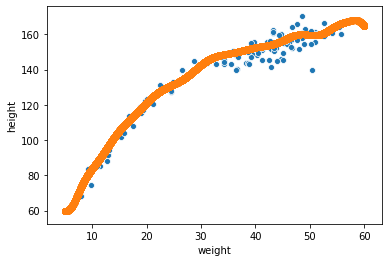

In [103]:
sns.scatterplot(X_holdout['weight'], y_holdout['height'])
plt.scatter(Xpred['weight'], full_pipeline2.predict(Xpred))

All of a sudden we see that the better model now performs considerably __worse__ on the new data, while the original model (Poly(i=2)) still has a similar $R^2$ score. This is __variance__

## Variance

Variance is an error from sensitivity to small fluctuations in the training set (the data we trained our model on, in the example above it was X_subset, y_subset). It is more commonly known as __overfitting__.

In our example, we overfit a model to the data we had available to us so much, that the model no longer represented the true, real world relationship between height and weight and gender. Below is a great illustration of overfitting from [this article](https://hackernoon.com/memorizing-is-not-learning-6-tricks-to-prevent-overfitting-in-machine-learning-820b091dc42)

![variance](img/variance.png)

* The plot to the right has high bias, and low variance. 
* The middle plot has low bias, and high variance
* The plot on the right has bias and variance just right

A model with high variance is one that tends to model the random noise in the training set, rather than the true relationship

## Bias

Bias error is the inability to properly specify a proper model. To put it simply, high bias is when the model doesn't pay much attention to the training data you give it. Some possible causes are:
 * Having too much __regularization__ (we'll get into that later_
 * Not creating or capturing enough features that have a strong relationship with the target variable
 * Using a linear model to try and capture a higher order Polynomial relationship 
 
## The Bias / Variance Tradeoff

There's an amazing equation to capture this balance:

$$
Error = Bias^2 + Variance + Irreducible\:Error
$$

Irreducible error is the error that you cannot capture with your model no matter what the circumstances are. It's the random noise of the dataset.

This equation is interesting, because it signals an important relationship between bias and variance: __they have an inverse relationship__.

As you can see in the image below, as bias decreases, variance increases, and as vice-versa.

![tradeoff](img/tradeoff.png)

_The optimal model is the one that minimizes both bias and variance_

So how can we generate scoring for our models that properly reflect bias and variance? After all, we saw in our above example that the model with the best $R^2$ score wasn't the best model to use. 

The most popular techniques are the __Validation Set Strategy__ and __Cross Validation__

# Section 10: Validation Set Strategy and Cross-Validation

<a id = "validation"></a>

---

## Validation Set Strategy

The __Validation Set strategy__ is when you train your model on a __training set__ and subsqequently evaluate it on a __testing set__, and then choose the model that performs the best on your chosen error metric. As a final step, you validate your work by evaluating the model on another set that was held out, the __validation set__.

It is important to note that the validation set approach can actually lead to overestimating the true test error, since in this approach the training set is significantly limited in size to create the test set and holdout set. This is an introduction of __bias__

Another important key point is that you should not make any of your modeling decisions based on the validation set, and look at that dataset as little as possible, otherwise you can introduce what is known as __Data Leakage__. 


### Data Leakage

Data leakage is when information from outside the training set is inadvertantly introducd to the model. Data Leakage can allow the model to learn information directly from the target variable, or data that it otherwise would not have had available to it in a real world situation. Typically if you have a prediction performance that seems *too good to be true*, it most likely is. Some examples are:
 * Creating features from the target variable
 * Using Standardization that includes data from the Validation Set
  - This is because the mean and standard deviation would use observations from the Validation Set in their calculation
 * Looking at the data in the Validation Set and inadvertantly making modeling decisions based on it
 
#### A Quick Look at Error Metrics
A list of some common error metrics are below:
 - $R^2$ and Adjustsed $R^2$
 - Mean Squared Error (MSE)
 - Mean Absolute Error (MAE)
 - Root Mean Squared Error (RMSE)
 - Root Mean Log Squared Error (RMLSE) 
 
Choosing an error metric is important, and some perform better in certain situations than others. I won't go into error metrics here, but below are a few resources that discusses them further. 

 * https://medium.com/@george.drakos62/how-to-select-the-right-evaluation-metric-for-machine-learning-models-part-1-regrression-metrics-3606e25beae0?
 * https://www.dataquest.io/blog/understanding-regression-error-metrics/


For this notebook, the main error metric we have used is $R^2$, not because it is a better error metric, but moreso because it is an error metric most people are already somewhat familiar with. In practice, it might be more common to see `Mean Squared Error`, since it gives more weight to outliers, or `Mean Absolute Error` which is common in finance because it is extremely interpretable.
 

### Walking through the Validation Set Strategy

It's easy to accomplish the Validation Set Strategy with Sklearn's `train_test_split`. In this case we'll perform a 60:20:20 split, were 60% of the data is in the training set, 20% is in the testing set, and 20% is in the validation set

In [104]:
# Loading in data
from sklearn.model_selection import train_test_split
Howell1 = 'https://github.com/rmcelreath/rethinking/raw/master/data/Howell1.csv'
df = pd.read_csv(Howell1, delimiter=';')
# df = df[df.age >= 18] # Only looking at individuals over 18 years old
X = df[['weight', 'male']]; y = df[['height']];

In [105]:
# Splitting Data

def validation_split(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)
    X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size=0.5)
    return X_train, X_test, X_validate, y_train, y_test, y_validate
    
X_train, X_test, X_validate, y_train, y_test, y_validate = validation_split(X,y)


As you can see, the split is roughly 60:20:20

In [106]:
len(X_train), len(X_test), len(X_validate)

(326, 109, 109)

We'll now compare 3 different models, `Poly(i=2)`, `Poly(i=3)`, and `Poly(i=4)`. 

In [107]:
numerical_preprocess = Pipeline([
    ( 'poly', PolynomialFeatures(degree=2, include_bias=False) ),
    ( 'scaler', StandardScaler() )
])

preprocess = ColumnTransformer([
        ( "num", numerical_preprocess, numerical_attributes ), 
        ( "cat", Binarizer(), categorical_attributes )
    ])
# Creating our full pipeline
full_pipeline = Pipeline([
    ("pre", preprocess),
    ('LR', LinearRegression(fit_intercept=True))
])

Notice that we can set the `PolynomialFeatures` `degree` parameter from outside of our pipeline, using the strings that we specified in the pipeline, and linking them with `__`

### Poly(i=2)

In [108]:
full_pipeline.set_params(pre__num__poly__degree = 2).fit(X_train, y_train)
full_pipeline.score(X_test, y_test)

0.9527272483374215

### Poly(i=3)

In [109]:
full_pipeline.set_params(pre__num__poly__degree = 3).fit(X_train, y_train)
full_pipeline.score(X_test, y_test)

0.9639264314205187

### Poly(i=4)

In [110]:
full_pipeline.set_params(pre__num__poly__degree = 4).fit(X_train, y_train)
full_pipeline.score(X_test, y_test)

0.9626451680480642

After looking at these three, we see Poly(i=3) performs the best, althoughn it's a marginal improvement over Poly(i=2) and Poly(i=4). Remember, __it's always better to choose models with less complexity,__ so in this case choosing Poly(i=2) or Poly(i=3) are both valid choices. We'll now see how both of these perform on the validation set.

For making prediction on the validation set, we can now add the testing set into our training set and train the model on both of these data sources

In [111]:
X_train2 = pd.concat((X_train, X_test))
y_train2 = pd.concat((y_train, y_test))

In [112]:
full_pipeline.set_params(pre__num__poly__degree = 2).fit(X_train2, y_train2)
full_pipeline.score(X_validate, y_validate)

0.9624962775393482

In [113]:
full_pipeline.set_params(pre__num__poly__degree = 3).fit(X_train2, y_train2)
full_pipeline.score(X_validate, y_validate)

0.9729903644112409

Great, it looks like a 3rd-order Polynomial function fits the best model! It's very robust to different random slices of the data. 

_Remember to keep in mind that the data you have available to you is just a small-world representation of the true relationship that exists out there in the larger world. You never know how well your model will perform on newly available data, but using strategies such as these can give you really good estimates of a true relationship._

## K-fold Cross Validation

__Cross validation is an even better strategy for model evaluation.__ To be clear, it is typically performed on the training set. The model with the best cross validation score is typically the final model you choose.

`K-fold Cross validation` is when you divide your data into `k` random datasets (also called `folds`), we'll choose `k=10` for this example, and then train your model 10 times, each time choosing 1 different fold for evaluation and training on the remaining 9 folds. 

Here's a better explanation through an illustration from [this article](http://ethen8181.github.io/machine-learning/model_selection/model_selection.html)

![cv](img/cv.png)

__So why choose `k=5` or `k=10`?__

Both `k=5` and `k=10` are two of the most commonly used number of folds in cross-validation because they were empirically shown to be 2 of the best parameters. 

If you think about it, you could use as many folds as there are data points in training set. If you have 500 data points, you could train the model on 499 of them and make the prediction on just 1 data point. This is known as __Leave One Out Cross Validation (LOOCV)__  and it is entirely valid.

However, LOOCV has some disadvantages, which is why it isn't as common in practice.

__First__, it is computationally expensive, especially with larger datasets since you are fitting and evaluating a model `n` times where `n` is the number of observations in the training set.

__Second__, it does not balance the `bias-variance tradeoff` as well as `K-fold CV`. As we saw with the validation set strategy, limiting the size of the training set introduced bias. In contrast, LOOCV is an unbiased estimator since the training set is simply of size `n-1`. This sounds great, but __remember a decrease in bias comes at a price; as bias decreases, variance increases__. It turns out that choosing `k=5` or `k=10` folds is better than LOOCV because it introduces less variance, while still reducing bias. 

See why the bias variance tradeoff is so important now?

### Data Leakage in Cross Validation

A common cause of data leakage in cross validation happens when Standardizing. To avoid it, standardization should happen after the folding process. Once you've separated your data into k folds, separate it into your training set and your testing set. Then, standardize your data based on __ONLY__ the training set's mean and standard deviation. 

In contrast, if you were to standardize your data before the K-fold process, information from the testing set would be leaked into the training set. To be more specific, when calculating the mean and standard deviation for Standardization, observations from the testing set would be used in that calculation.

Luckily, sklearn's Cross Validation modules automatically perform standardization after the K-fold process, as long as you use a `Pipeline` object to contain both your `StandardScaler` object and your `Estimator` (an estimator is just sklearns terminology for a model).

### Let's implement K-fold cross validation

In [114]:
from sklearn.model_selection import cross_val_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [115]:
pipe2 = full_pipeline.set_params(pre__num__poly__degree = 2)

cv_demo = cross_val_score(pipe2, X_train, y_train, cv=10)
cv_demo

array([0.96873556, 0.9430409 , 0.95502547, 0.9706251 , 0.96909817,
       0.96382992, 0.96517843, 0.97249862, 0.91295249, 0.96261967])

As you can see, we had 10 folds so there are 10 different $R^2$ values. We get the CV score by taking the mean of these scores 

In [116]:
cv_demo.mean()

0.9583604322856705

We can also choose many different scoring metrics. Another common scoring metric is `mean squared error (MSE)`. Sklearn calculates it as negative mean squared error for efficiency reasons, but it's very easy to transform this back to MSE.

In [117]:
(cross_val_score(
        pipe2, 
        X_train, 
        y_train, 
        cv=10, 
        scoring='neg_mean_squared_error'
    ) * -1
).mean()

29.709729328094994

Let's evaluate our 3 models with 10-Fold cross-validation

In [118]:
pipe2 = full_pipeline.set_params(pre__num__poly__degree = 2)
cross_val_score(pipe2, X_train, y_train, cv=10).mean()

0.9583604322856705

In [119]:
pipe3 = full_pipeline.set_params(pre__num__poly__degree = 3)
cross_val_score(pipe3, X_train, y_train, cv=10).mean()

0.9702543125194121

In [120]:
pipe4 = full_pipeline.set_params(pre__num__poly__degree = 4)
cross_val_score(pipe4, X_train, y_train, cv=10).mean()

0.970117280601686

Once again, the $weight^3$ model is the best performing model. As a final validation, we will make a prediction on the testing set

In [121]:
pipe3 = full_pipeline.set_params(pre__num__poly__degree = 3)
pipe3.fit(X_train, y_train)
pipe3.score(X_test, y_test)

0.9689451724379476

The Polynomial(i=3) looks like the best fitting model to capture this relationship! 

### Summary

 * Validation Set Strategy and Cross Validation can be used to properly estimate the true test error rate
 * When using the Validation Set Strategy, it's important you don't look at the validation set until you have already chose 1-2 of the best performing models. Making modeling decisions based on your holdout set leads to __data leakage__ which will ruin the validity of your modeling process.
 * When Cross Validating, if you are standardizing your data, it's important that you standardize your data *after* designating your folds. Otherwise, you would introduce __data leakage__.
 * The Bias Variance Tradeoff is a central issue to Data Science that your should always keep in mind.

# Section 11: A Quick Introduxtion to Regularized Regression

<a id = "regularization"></a>

---

Regularization is a powerful technique that reduces variance to help prevent overfitting. *Just remember that this comes at the price of increasing bias*

Here's a great illustration of the process from [wikipedia](https://en.wikipedia.org/wiki/Regularization_(mathematics)), where the blue line is an overfit model, and the green line is the same overfit model, but with a regularization term, $\lambda$, applied.

![regularization](img/regularization.png)

The two most common approaches are Lasso Regression (L1 Regularization), and Ridge Regression (L2 Regularization).

## Lasso Regression (L1 Regularization)

Lasso regression differs from Linear Regression in one key way, the regularization term $a$. The __cost function__, the function used to find the best parameters for the model (you might remember we used SSE for linear regression) for Lasso Regression is the following:

$$
Cost(\theta) = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + a \sum_{i=1}^{n} | \hat{\beta} |
$$

This penalty term adds the absolute value of the magnitude of the coefficients to the SSE. As the value of lambda increases, more regularization is applied.

Here's an example of an overfit model with regularization applied

In [122]:
X = np.random.normal(120,15, 10)
y = 0.4*X + np.random.normal(0, 4, 10)

# Creating a pipeline object

preprocess = Pipeline([
    ( 'poly', PolynomialFeatures(degree=10, include_bias=False) ),
    ( 'std_scaler', StandardScaler() )
])

full_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('LR', LinearRegression(fit_intercept=True))
])

Here's what the overfit model looks like. It's just a model with a 10th order Polynomial term

(90, 175)

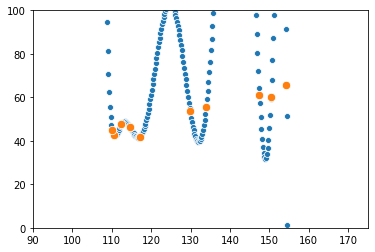

In [123]:
full_pipeline.fit(X.reshape(-1,1), y)

X_pred = np.linspace(0, 200, num=1000)
y_pred_overfit = full_pipeline.predict(X_pred.reshape(-1,1))
sns.scatterplot(X_pred, y_pred_overfit)
sns.scatterplot(X,y, s=70)

plt.ylim(0,100)
plt.xlim(90,175)

Now we'll add L1 Regularization to the 10th order Polynomial data, through a Lasso model with $a = 0.001$.

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7299834819375235, tolerance: 0.06552734348942893
  positive)


(90, 170)

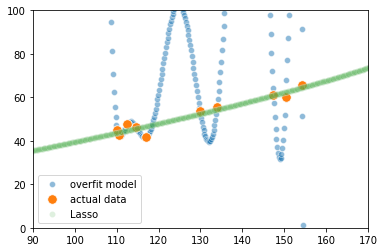

In [124]:
from sklearn.linear_model import Lasso

# Creating our lasso pipeline
lasso_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('Lasso', Lasso(alpha=0.001))
])

lasso_pipeline.fit(X.reshape(-1,1), y)

y_pred = lasso_pipeline.predict( X_pred.reshape(-1,1) )
sns.scatterplot(X_pred, y_pred_overfit, alpha = 0.5, label = 'overfit model')
sns.scatterplot(X,y, s=90, label='actual data');
sns.scatterplot(X_pred, y_pred, alpha = 0.15, label = 'Lasso');
plt.ylim(0,100); plt.xlim(90,170)

Now we'll add L1 Regularization to the 10th order Polynomial data, through a Lasso model with $a = 1.0$.

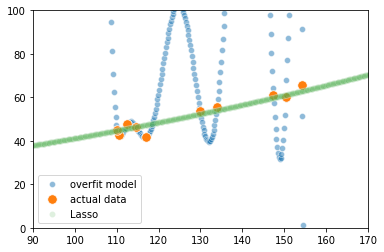

In [125]:
lasso_pipeline2 = lasso_pipeline.set_params(Lasso__alpha=1.0)
lasso_pipeline2.fit(X.reshape(-1,1), y)

y_pred = lasso_pipeline2.predict( X_pred.reshape(-1,1) )
sns.scatterplot(X_pred, y_pred_overfit, alpha = 0.5, label = 'overfit model')
sns.scatterplot(X,y, s=90, label='actual data');
sns.scatterplot(X_pred, y_pred, alpha = 0.15, label = 'Lasso');
plt.ylim(0,100); plt.xlim(90,170);

And finally we'll fit a model with $a = 10$. As you can see, so much regularization was added that the predictions simply become the mean of the y data 

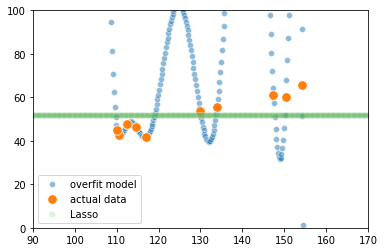

In [126]:
lasso_pipeline2 = lasso_pipeline.set_params(Lasso__alpha=10)
lasso_pipeline2.fit(X.reshape(-1,1), y)

y_pred = lasso_pipeline2.predict( X_pred.reshape(-1,1) )
sns.scatterplot(X_pred, y_pred_overfit, alpha = 0.5, label = 'overfit model')
sns.scatterplot(X,y, s=90, label='actual data');
sns.scatterplot(X_pred, y_pred, alpha = 0.15, label = 'Lasso');
plt.ylim(0,100); plt.xlim(90,170);

One huge advantage of Lasso regression is that if you have a lot of X variables (this is typically referred to a wide dataset), and you're not sure which ones are useful predictors, Lasso Regression actually sets the Beta Coefficients of those unimportant predictors to 0. In contrast, Ridge regression is not capable of this. 

## Ridge Regression (L2 Regularization)

Ridge Regression is very similar to Lasso regression, but instead of using the L1 norm as a penalty function, it uses the L2 norm as a penalty function

$$
Cost(\theta) = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + a \sum_{i=1}^{n} \hat{\beta}^2
$$

This penalty term adds the sum of squares of the coefficients to the SSE. The higher the value of $a$, the more regularization that is applied.

Here's we'll an L2 Regularization to the 10th order Polynomial data, through a Ridge model with  `𝑎= 0.00000001` .

(90, 170)

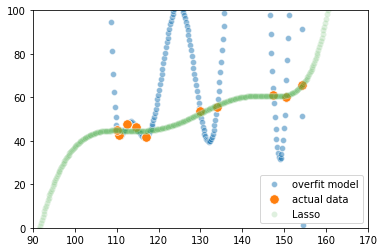

In [127]:
from sklearn.linear_model import Ridge

# Creating our lasso pipeline
ridge_pipeline = Pipeline([
    ("preprocess", preprocess),
    ('Ridge', Ridge(alpha=0.00000001))
])

ridge_pipeline.fit(X.reshape(-1,1), y)

y_pred = ridge_pipeline.predict( X_pred.reshape(-1,1) )
sns.scatterplot(X_pred, y_pred_overfit, alpha = 0.5, label = 'overfit model')
sns.scatterplot(X,y, s=90, label='actual data');
sns.scatterplot(X_pred, y_pred, alpha = 0.15, label = 'Lasso');
plt.ylim(0,100); plt.xlim(90,170)

And here's ridge regression with $a = 1$. 

(90, 170)

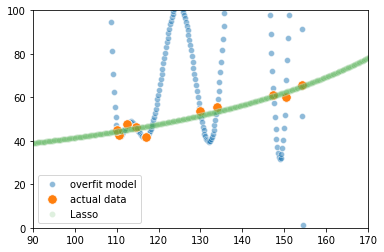

In [128]:
ridge_pipeline.set_params(Ridge__alpha = 1)

ridge_pipeline.fit(X.reshape(-1,1), y)

y_pred = ridge_pipeline.predict( X_pred.reshape(-1,1) )
sns.scatterplot(X_pred, y_pred_overfit, alpha = 0.5, label = 'overfit model')
sns.scatterplot(X,y, s=90, label='actual data');
sns.scatterplot(X_pred, y_pred, alpha = 0.15, label = 'Lasso');
plt.ylim(0,100); plt.xlim(90,170)

## Elastic Net

Elastic Net is simply a combination of both Ridge Regression and Lasso Regression. It's cost function contains both an $a$ parameter, which controls the regularization, and an $r$ parameter, which controls how much of Elastic Net regulatization is L1 vs. L2 regularization.

$$
Cost(\theta) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + ra \sum_{i=1}^{n} |\hat{\beta}| + \frac{1-r}{2} a \sum_{i=1}^{n} \hat{\beta}^2
$$

If $r=1$, Elastic Net regularization is just L1 regularization (Lasso). If $r=0$, Elastic Net regularization is just L2 regularization (Ridge). Otherwise, anything in between is a mixture of the two. 

__So in what situations should you use Linear Regression vs. Lasso vs. Ridge vs. Elastic Net?__

Many actually argue that when making predictive models, it's almost always preferable to have atleast a little regularization, so it might be worth keeping in mind when you're modeling. Ridge regression is a great place to start, but if you think that there might be useless features in your model, you might want to consider Elastic Net. Usually Elastic Net is always preferable to Lasso regularization, since Lasso regularization can be erratic whenthe number of preductirs is greater than the number of observations (p > n), or when there's multicollinearity ([citing heavily from Hands On ML2 by Aurelien Geron here](https://github.com/ageron/handson-ml2)).

## Implementing Regularized Regression

Let's go ahead and implement regularized regression on a dataset I've put together, where we're predicting the number of park in NYC using tax return data

In [129]:
df = pd.read_csv('./data/nyc_playgrounds.csv').set_index('zipcode')
df.head()

,Accessible,Adaptive_Swing,School,Status_closed,Status_open to the public,Status_two playgrounds,Status_weekdays,Status_weekends,Level_1.0,Level_2.0,...,mean_06500,mean_10300,mean_85530,mean_85300,mean_11901,mean_11902,borough_mean_household_agi,borough_mean_agi,normalized_A00100,normalized_mean_household_agi
zipcode,,,,,,,,,,,,,,,,,,,,,
10001,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42.483177,42.088372,3.137879,4.214881,10.891033,5.326771,202.512535,3.576709e+06,0.640616,0.779225
10002,22.0,4.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,...,13.327646,12.276163,1.648438,2.770093,3.899556,2.708955,202.512535,3.576709e+06,0.637884,0.267096
10003,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,59.522414,60.198156,3.575734,6.484355,12.985185,7.741337,202.512535,3.576709e+06,1.851658,1.141081
10007,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,240.597078,241.396541,5.728571,15.470968,24.500000,38.837572,202.512535,3.576709e+06,0.845437,4.340649
10009,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.755124,16.527193,1.621212,3.056818,5.253977,2.826517,202.512535,3.576709e+06,0.719689,0.392191


We can use `.shape` on a dataframe to find out how many rows (observations) and columns (features) there are. `.shape` outputs in the format (rows, columns)

In [130]:
df.shape

(186, 105)

We'll also take a quick look at a heatmap of correlations to identify multicolllinearity. There's alot in this dataset.

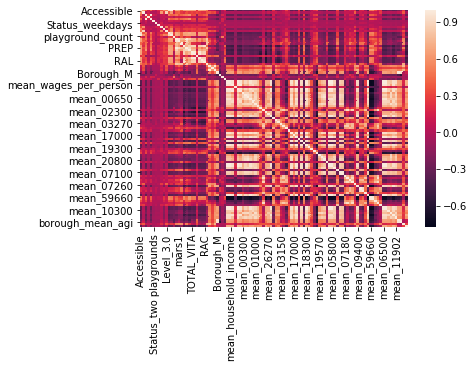

In [131]:
sns.heatmap(df.corr())

In [132]:
X, y = df.drop('playground_count',axis=1) ,df['playground_count']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=RANDOM_STATE)

Let's start with Linear Regression on this dataset. We'll evaluate with cross-validation using $R^2$ as our error metric

#### Linear Regression

In [133]:
LR = Pipeline([
    ('scaler', StandardScaler()),
    ('LR', LinearRegression())
])

cross_val_score(LR, X_train, y_train, cv=10).mean()

0.32022034177992875

Linear Regression doesn't cut it in this case, nor was it a good idea to begin with given there are so many features.

#### Ridge Regression

*We'll use the default alpha value for simplicity*

In [134]:
ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

cross_val_score(ridge, X_train, y_train, cv=10).mean()

0.959568691313056

That far outperforms Linear Regression

#### Lasso Regression

We'll try Lasso Regression next

In [135]:
lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso', Lasso())
])

cross_val_score(lasso, X_train, y_train, cv=10).mean()

0.9321896750073402

The lasso model is also performing well. If we look at the Beta Coefficients from this model, the non-useful features are set to zero  which is incredibly usefull for feature selection

In [136]:
lasso.fit(X_train, y_train)
lasso['lasso'].coef_

array([ 3.86768472,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        ,  0.        , -0.        ,
       -0.        , -0.        ,  0.        ,  0.        , -0.  

however keep in mind that in this case there are almost as many features as their are observations, and there is a lot of multicollinearity in this dataset. This is textbook use case for Elastic Net.

#### Elastic Net

We can adjust the r parameter with `l1_ratio`

In [137]:
from sklearn.linear_model import ElasticNet
EN = Pipeline([
    ('scaler', StandardScaler()),
    ('EN', ElasticNet(l1_ratio=0.5))
])

cross_val_score(EN, X_train, y_train, cv=10).mean()

0.8987207955437502

In [138]:
EN.fit(X_train, y_train)
EN['EN'].coef_

array([ 1.41402257,  0.36096419,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.40204743,
        0.1135959 ,  1.23052554,  0.        ,  0.15485149,  0.06581246,
        0.        ,  0.        ,  0.05079246,  0.17137908,  0.03499489,
        0.10065614, -0.        ,  0.12620929,  0.11688814,  0.02058107,
        0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        , -0.        , -0.        ,
       -0.        ,  0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.        ,  0.        ,  0.        , -0.  

Interestingly enough, Elastic Net didn't outperform Lasso regression, which goes to show that it's always worth evaluating multiple models. As we can see above, Elastic Net was also good for identifying important features, a trait which Ridge does not have

### Parameter Tuning

We'll do a quick parameter tuning to find the best values of $r$ and $a$ for Elastic Net. Parameter Tuning is an evaluation to find the best Model Parameters that result in the best model score. It's important that if you evaluate on a train/test split, you keep a holdout set to evaluate on after you've chosen your best model. Even better, just __use cross validation__.

In [139]:
from sklearn.model_selection import RandomizedSearchCV

params = {'EN__alpha':scs.uniform(), 'EN__l1_ratio':scs.uniform()}
clf = RandomizedSearchCV(EN, params, random_state=RANDOM_STATE)

search = clf.fit(X_train, y_train)
search.best_params_

{'EN__alpha': 0.09361309329775258, 'EN__l1_ratio': 0.813308412782129}

As shown above, we were able to identify 2 of the best parameters to use for this model. We'll show another approach to identify the best parameters using visualizations below 

In [140]:
import warnings
warnings.filterwarnings('ignore')

Text(0.5, 0, 'alpha')

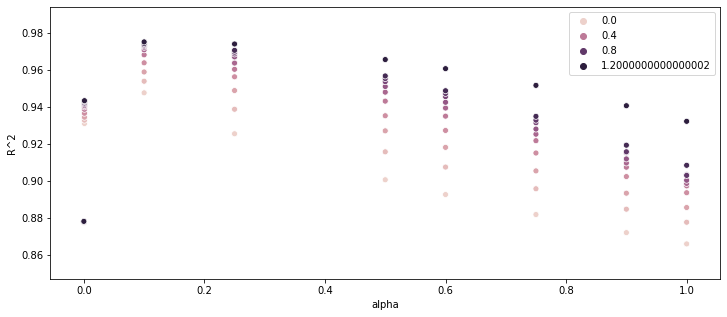

In [141]:
results = []
for alpha in [0.00001, 0.001, 0.1, 0.25, 0.5, 0.6, 0.75, 0.9, 1]:
    for l1_ratio in np.arange(0,1.1,0.1):
        EN.set_params(EN__alpha = alpha, EN__l1_ratio = l1_ratio)
        results.append([alpha, l1_ratio, cross_val_score(EN, X_train, y_train,cv=10).mean()]) 
results= np.array(results)

fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.scatterplot(results[:,0], results[:,2], hue = results[:,1], ax=ax)
ax.set_ylabel('R^2')
ax.set_xlabel('alpha')

In the plot above, $r$ is represent by the color.

As you can see, the highest $R^2$ matches closely to the Randomized CV search. It might be more common to see a plot like this but with Mean Squared Error, which as opposed to $R^2$, you hope to minimize

Text(0.5, 0, 'alpha')

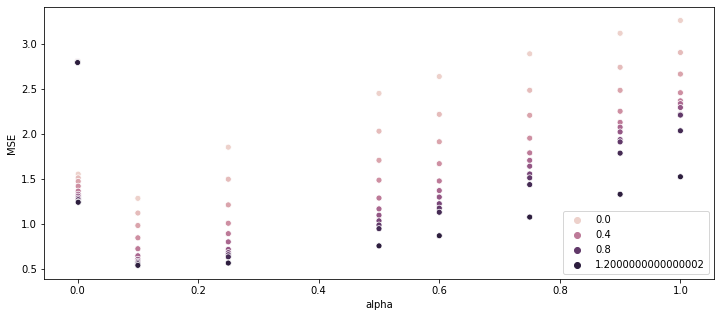

In [142]:
results = []
for alpha in [0.00001, 0.001, 0.1, 0.25, 0.5, 0.6, 0.75, 0.9, 1]:
    for l1_ratio in np.arange(0,1.1,0.1):
        EN.set_params(EN__alpha = alpha, EN__l1_ratio = l1_ratio)
        results.append([alpha, l1_ratio, (cross_val_score(EN, X_train, y_train,cv=10, 
                                                         scoring='neg_mean_squared_error')*-1).mean()]) 
results= np.array(results)

fig, ax = plt.subplots(1,1, figsize=(12,5))
sns.scatterplot(results[:,0], results[:,2], hue = results[:,1], ax=ax)
ax.set_ylabel('MSE')
ax.set_xlabel('alpha')

And finally, we'll evaluate these models.

In [143]:
EN.set_params(EN__alpha=search.best_params_['EN__alpha'], 
              EN__l1_ratio= search.best_params_['EN__l1_ratio'])

cross_val_score(EN, X_train, y_train, cv=10).mean()

0.9735590794320761

In [144]:
EN.set_params(EN__alpha=0.09361309329775258, EN__l1_ratio=0.813308412782129)
EN.fit( X_train, y_train)
EN.score(X_test, y_test)

0.9568257433501193